# Bigram Frequency Comparison 

Comparing co-occurrence frequencies of: 
1. bigram baseline  $=\{$`RBXadj`$\}$ 
2. directly negated bigrams $=\{$`RBdirect`$\}$
3. and the difference between these sets  $=\{$`RBXadj`$\} - \{$`RBdirect`$\}$

In [1]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from source.analyze.count_bigrams import describe_counts
from source.utils.dataframes import (corners, print_md_table, set_count_dtype, sort_by_margins,
                                     square_sample, transform_counts)
from source.utils.general import print_iter, confirm_dir
from source.utils.visualize import heatmap

In [2]:
FREQ_OUT = Path('/share/compling/projects/sanpi/results/freq_out')
N_FILES = 35
THR_DEC_STR = '001'

## Define Helper Functions

In [3]:
def sample_counts(frq_table, label,
                  rows=pd.Series(dtype='string'),
                  columns=pd.Series(dtype='string'),
                  color="nipy_spectral_r"):
    # color = 'Set1'
    # color = 'gist_rainbow'

    s = frq_table.copy()
    if not any(rows):
        s = s[s.index != 'SUM']
        s = s.iloc[5:int(frq_table.shape[0]*0.4),
                   :] if len(s.index) >= 80 else s
        rows = s.sample(min(len(s), 16)).index
    if not any(columns):
        s = s.loc[:, s.columns != 'SUM']
        s = s.iloc[:, 5:int(frq_table.shape[1]*0.4)
                   ] if len(s.columns) > 50 else s
        columns = s.T.sample(min(len(s.T), 8)).index
    sample_df = s.loc[rows, columns]
    # print(sample_df.describe().T.round(2).to_markdown())
    # fig = plt.figure(figsize=(6, 8), dpi=300)
    fig = plt.figure(dpi=130)
    # ax.barh(s20x10, width=1)
    sample_df.plot(kind='barh',
                   width=0.8,
                   figsize=(8, 10),
                   position=1,
                   title=f'{label} of sample',
                   grid=True,
                   colormap=color,
                   # colormap="gist_rainbow",
                   # colormap="rainbow",
                   #  colormap="brg",
                   #   colormap="nipy_spectral_r",
                   #    colormap="Set1",
                   ax=plt.gca())
    plt.show()
    fig = plt.figure(dpi=150)
    sample_df.plot(kind='barh',
                   stacked=True,
                   width=0.8,
                   figsize=(8, 10),
                   position=1,
                   title=label,
                   grid=True,
                   colormap=color,
                   # colormap="gist_rainbow",
                   #  colormap="brg",
                   #    colormap="nipy_spectral_r",
                   #    colormap="Set1",
                   ax=plt.gca()
                   )
    plt.show()

    heatmap(sample_df, size=(8, 10)) #default colormap ➡️ `'plasma'`
    # print(sample_df.round().to_markdown(floatfmt=',.0f'))

    return s, sample_df


def seek_frq_table(meta_tag, parent_dir: str = 'RBdirect', stem_glob: str = None):

    stem_glob = stem_glob or f'all*adj-x-adv*{meta_tag}*'
    glob_dir = FREQ_OUT.joinpath(parent_dir)

    try:
        frq_path = list(glob_dir.glob(f'{stem_glob}.pkl.gz'))[0]

    except IndexError:
        try:
            frq_path = list(glob_dir.glob(f'{stem_glob}.csv'))[0]
        except IndexError:
            print('⚠️ frequency table corresponding to '
                  f'{stem_glob} not found in {parent_dir}.')
    return frq_path


def locate_freq_tables():

    meta_tag = f'thr0-{THR_DEC_STR}p.{N_FILES}f'
    print('# Comparing Bigram Frequencies by Polarity\n',
          f'- for `{N_FILES}` corpus input `.conll` directories containing source `.conllu` files',
          (f'- with word types limited to only those that account for at least $0.{THR_DEC_STR}\%$'
           f' of the cleaned dataset (as sourced from {N_FILES} corpus file inputs)'),
          f'- file identifier = `{meta_tag}`',
          sep='\n')
    paths = [
        seek_frq_table(meta_tag, d) for d in ('RBdirect', 'RBXadj')]

    global_count_floor = re.search(r'=(\d+)\+', paths[1].stem).groups()[0]
    print('- pattern matches restricted to only token word types with at least '
          f'`{global_count_floor}` total tokens across all combinations')
    print_iter((f'`{p}`' for p in paths),
               bullet='-', indent=2,
               header='- Selected Paths')
    return paths


def load_freq_table(frq_path):
    # // return set_count_dtype(pd.read_pickle(frq_pkl), frq_pkl)
    frq_df = pd.read_csv(
        frq_path) if frq_path.suffix == '.csv' else pd.read_pickle(frq_path)
    meta_col = frq_df.columns[frq_df.columns.str.contains(
        '_')].to_series().squeeze()
    if any(meta_col):
        if frq_df.index.name:
            frq_df = frq_df.reset_index()

        frq_df = frq_df.set_index(meta_col)

    elif not frq_df.index.name:
        frq_df.index.name = 'adj_form_lower'

    if not frq_df.columns.name:
        frq_df.columns.name = 'adv_form_lower'

    frq_df = frq_df.apply(pd.to_numeric, downcast='unsigned')

    if frq_path.suffix == '.csv':
        frq_df.to_pickle(frq_path.with_suffix('.pkl.gz'))
    return frq_df

### Moved to `source.utils`

In [4]:
# NOTE: This is now imported from `source.utils.visualize`
# def heatmap(df, columns=None, save_name=None, size=(8, 10)):
    # plt.figure(figsize=size, dpi=120, facecolor="white")
    # adv_labels = df.index
    # if columns:
    #     df = df.loc[:, columns]
    # df = df.astype('float')
    # # Displaying dataframe as an heatmap
    # # with diverging colourmap as RdYlBu
    # plt.imshow(df, cmap="plasma")
    # # plt.imshow(df, cmap="gist_rainbow")
    # # plt.imshow(df, cmap="jet")
    # # plt.imshow(df, cmap="viridis")
    # # plt.autoscale(enable=True, axis='both')
    # # Displaying a color bar to understand
    # # which color represents which range of data
    # plt.colorbar()
    # # Assigning labels of x-axis
    # # according to dataframe
    # plt.xticks(range(len(df.columns)), df.columns, rotation=-20)
    # # Assigning labels of y-axis
    # # according to dataframe
    # plt.yticks(range(len(df.index)), adv_labels)
    # # Displaying the figure
    # plt.show()


# NOTE: This is now imported from `source.utils.dataframes`
# def corners(df, size: int = 5):
    # index_name = df.index.name or 'frequencies'
    # columns_name = df.columns.name or 'categories'
    # df = df.reset_index().reset_index().set_index(
    #     ['index', index_name])
    # df = df.T.reset_index().reset_index().set_index(
    #     ['index', columns_name]).T
    # cdf = pd.concat(
    #     [dfs.iloc[:, :size].assign(__='...')
    #      .join(dfs.iloc[:, -size:])
    #      for dfs in (df.head(size).T.assign(__='...').T,
    #                  df.tail(size))])
    # cdf = cdf.reset_index().set_index(index_name)
    # cdf.pop('index')
    # cdf = cdf.T.reset_index().set_index(columns_name)
    # cdf.pop('index')
    # return cdf.T.rename(columns={'': '...'}, index={'': '...'})


## Locate Starting Frequency Data

In [5]:
neg_frq_path, all_frq_path = locate_freq_tables()

# Comparing Bigram Frequencies by Polarity

- for `35` corpus input `.conll` directories containing source `.conllu` files
- with word types limited to only those that account for at least $0.001\%$ of the cleaned dataset (as sourced from 35 corpus file inputs)
- file identifier = `thr0-001p.35f`
- pattern matches restricted to only token word types with at least `868` total tokens across all combinations

- Selected Paths
  - `/share/compling/projects/sanpi/results/freq_out/RBdirect/all-frq_adj-x-adv_thr0-001p.35f.pkl.gz`
  - `/share/compling/projects/sanpi/results/freq_out/RBXadj/all_adj-x-adv_frq-thr0-001p.35f=868+.pkl.gz`


# Comparing Bigram Frequencies by Polarity

- for `35` corpus input `.conll` directories containing source `.conllu` files
- with word types limited to only those that account for at least $0.001\%$ of the cleaned dataset (as sourced from 35 corpus file inputs)
- file identifier = `thr0-001p.35f`
- pattern matches restricted to only token word types with at least `868` total tokens across all combinations

- Selected Paths
  - `/share/compling/projects/sanpi/results/freq_out/RBdirect/all-frq_adj-x-adv_thr0-001p.35f.pkl.gz`
  - `/share/compling/projects/sanpi/results/freq_out/RBXadj/all_adj-x-adv_frq-thr0-001p.35f=868+.pkl.gz`


## _Negated_ Frequencies Overview

In [6]:
neg_only = load_freq_table(neg_frq_path)
# describe_counts(df=neg_only, df_path=neg_frq_path)

### Full Table Preview of _Negated_ Frequencies

In [7]:
corners(neg_only, 7)

adv_form_lower,SUM,as,so,too,very,more,that,...,repeatedly,unseasonably,doubtless,wondrously,preferably,seductively,fewer
adj_form_lower,,,,,,,,,,,,,,,
SUM,3148010,526827,341050,307870,191043,166176,165061,...,1,1,1,1,1,1,1
good,132226,44885,18002,3623,30349,32,10655,...,0,0,0,0,0,0,0
sure,128741,714,26584,8093,675,141,300,...,0,0,0,0,0,0,0
bad,105134,27740,21352,19520,316,8,16535,...,0,0,0,0,0,0,0
easy,87499,23376,17596,1207,2736,147,10158,...,0,0,0,0,0,0,0
clear,72836,3456,3255,473,2641,1369,516,...,0,0,0,0,0,0,0
available,55828,320,62,34,27,92,11,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
asymmetrical,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0


### (Semi-)Random Sample of _Negated_ Frequencies

In [8]:
ss_neg_15 = square_sample(neg_only.iloc[:301, :201], 15)
ss_neg_15


adv_form_lower,SUM,more,even,completely,real,extremely,perfectly,well,normally,aesthetically,consciously,reasonably,genuinely,uniformly,factually,visibly
adj_form_lower,,,,,,,,,,,,,,,,
SUM,3148010,166176,77229,33334,5486,5455,3253,2527,1841,1083,914,911,688,588,521,345
sure,128741,141,14520,2356,506,7,28,6,0,0,0,12,1,0,0,0
safe,7829,87,279,396,6,8,75,1,2,0,0,17,0,2,0,0
responsible,5597,95,70,68,2,0,0,0,2,0,0,0,0,0,0,1
small,4904,0,13,0,4,19,0,2,0,0,0,0,0,0,0,0
smooth,3944,5,5,164,9,4,110,0,1,0,0,0,0,3,0,0
unique,3450,78,39,90,0,3,0,0,0,3,0,0,3,0,0,0
profitable,2814,190,39,1,4,13,0,0,2,0,0,0,2,1,0,0
stable,2761,106,13,63,1,2,15,0,2,0,0,0,0,4,0,0


### Note

In a previous iteration, the negated counts "double-dipped" on the bigram counts. 
That is, in some instances, multiple negation triggers were found to have the requisite relationship with the bigram, 
and thus the single bigram token was counted as multiple separate negated tokens. 

The current counts were calculated from tables where all extraneous negation triggers were 
ignored—only the trigger closest to the bigram was retained.

## _All_ (negated and non-negated) Frequencies Overview

In [9]:
all_frq = load_freq_table(all_frq_path)

# describe_counts(all_frq, all_frq_path)
all_frq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3895 entries, SUM to oversized
Columns: 1006 entries, SUM to pointedly
dtypes: uint16(909), uint32(97)
memory usage: 8.2+ MB


### Full Table Preview of _All_ Frequencies

In [10]:
corners(all_frq, 6)

adv_form_lower,SUM,very,more,most,so,not,...,touchingly,on,emphatically,second-most,cosmetically,pointedly
adj_form_lower,,,,,,,,,,,,,
SUM,83284343,9913432,9320997,7568812,5735964,4415785,...,872,872,872,869,869,868
many,2210387,21237,373,140,1191864,58442,...,0,1,3,0,0,0
important,2199447,359610,306604,748533,105509,17351,...,0,0,2,105,9,0
good,2030480,507499,18902,5207,153196,96143,...,1,1,6,0,7,0
much,1776924,42365,102,22,614652,66410,...,0,95,0,0,0,1
likely,1048364,35899,498401,192635,847,46858,...,0,0,0,12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
intermittent,872,84,171,11,34,37,...,0,0,0,0,0,0
untrained,872,9,10,43,11,5,...,0,0,0,0,0,0


In [11]:
sort_by_margins(square_sample(all_frq.copy().iloc[:401, :301], 10))

adv_form_lower,SUM,now,physically,perhaps,financially,ultimately,dangerously,brand,specifically,globally,though
adj_form_lower,,,,,,,,,,,
SUM,83284343,438049,72333,57267,56025,37217,30254,14541,12581,12473,12473
serious,294776,130,4,18,3,19,7,0,6,1,22
helpful,204376,15,5,84,20,62,0,0,129,4,49
complicated,179503,18,5,12,12,2,14,0,5,0,7
greater,154275,465,4,382,2,24,0,0,3,0,19
willing,141652,1971,9,60,5,74,2,0,3,1,15
guilty,76860,108,0,63,1,15,0,0,1,0,0
satisfying,66053,2,45,8,20,258,4,0,3,0,2
emotional,58394,8,5,22,0,10,6,0,7,1,1


### Adjust the shapes

There are some bigrams that never occur with a direct negation, so the shapes of the loaded tables are different.
Add additional cells to `neg_only` for these missing forms (with values of `0`) to give the tables the same shape.

> ✅ sanity checks 👇

In [12]:
neg_only.shape

(3887, 1002)

In [13]:
all_frq.shape

(3895, 1006)

In [14]:
neg_only.loc[~neg_only.index.isin(all_frq.index), ~neg_only.columns.isin(all_frq.columns)]


adv_form_lower
adj_form_lower
NaN


In [15]:
all_frq.loc[~all_frq.index.isin(neg_only.index), ~all_frq.columns.isin(neg_only.columns)]

adv_form_lower,yearly,sparsely,legendarily,second-most
adj_form_lower,,,,
evolving,0,0,0,0
earliest,0,0,0,0
northerly,0,0,0,0
southerly,0,0,0,0
chopped,0,0,0,0
away,0,0,0,0
marrow,0,0,0,0
null,0,0,0,0
worldwide,10,0,0,0


In [16]:
neg_frq = set_count_dtype(neg_only.copy().reindex_like(all_frq).fillna(0), 
                          neg_frq_path.with_name(neg_frq_path.name.replace('all-frq', 'ALL-WORDS')))
neg_frq.shape

(3895, 1006)

In [17]:
all_frq.loc[~all_frq.index.isin(neg_frq.index), ~all_frq.columns.isin(neg_frq.columns)]

adv_form_lower
adj_form_lower


### ~~⚠️ #HACK manual override~~ No longer necessary

Some negation hits are double-dipping in the bigram set, when at best, this "double negation" type of set up is just **1** negated pattern match,
or it is not one at all, in the case of logical cancellation. 

Thus all `neg_frq` values will be capped at the corresponding `all_frq` value.



```python
any(neg_frq[neg_frq > all_frq])
neg_frq.isna().apply(any).value_counts()
neg_frq.columns.to_series().apply(lambda c: any(neg_frq[c] > all_frq[c])).value_counts()
```

_Following hack is no longer necessary_
```python
neg_gtr = neg_frq.copy()
neg_gtr = neg_gtr.mask(neg_frq > all_frq)
neg_gtr.isna().apply(any).value_counts()

neg_gtr.columns.to_series().apply(lambda c: any(neg_gtr[c] > all_frq[c])).value_counts()
neg_gtr.update(all_frq, overwrite=False)
neg_gtr.isna().apply(any).value_counts()
neg_gtr.columns.to_series().apply(lambda c: any(neg_gtr[c] > all_frq[c])).value_counts()
neg_frq = neg_gtr.apply(pd.to_numeric, downcast='unsigned')

updated_neg_pkl = neg_frq_path.with_name(neg_frq_path.name.replace('all-frq', 'ALL-WORDS'))
print(f"negation frequency table with updated indexing as {updated_neg_pkl}")
neg_frq.to_pickle(updated_neg_pkl)
```

### Words with 0 tokens in the `RBdirect` results


#### Adjectives

In [18]:
print(all_frq.loc[~all_frq.index.isin(neg_only.index), ['SUM']].join(neg_frq.loc[~neg_frq.index.isin(neg_only.index), ['SUM']], rsuffix='_negated').to_markdown(floatfmt=',.0f'))


| adj_form_lower   |   SUM |   SUM_negated |
|:-----------------|------:|--------------:|
| evolving         | 3,141 |             0 |
| earliest         | 2,199 |             0 |
| northerly        | 1,890 |             0 |
| southerly        | 1,426 |             0 |
| chopped          | 1,293 |             0 |
| away             | 1,291 |             0 |
| marrow           | 1,168 |             0 |
| null             | 1,063 |             0 |
| worldwide        |   963 |             0 |


| adj_form_lower   |   SUM |   SUM_negated |
|:-----------------|------:|--------------:|
| evolving         | 3,141 |             0 |
| earliest         | 2,199 |             0 |
| northerly        | 1,890 |             0 |
| southerly        | 1,426 |             0 |
| chopped          | 1,293 |             0 |
| away             | 1,291 |             0 |
| marrow           | 1,168 |             0 |
| null             | 1,063 |             0 |
| worldwide        |   963 |             0 |


#### Adverbs

In [19]:
# print(all_frq.loc[['SUM'], ~neg_frq.columns.isin(neg_only.columns)].join(neg_frq.loc[['SUM'], ~neg_frq.columns.isin(neg_only.columns)], rsuffix='_negated').to_markdown(floatfmt=',.0f'))
print(all_frq.T.loc[~all_frq.T.index.isin(neg_only.T.index), ['SUM']].join(neg_frq.T.loc[~neg_frq.T.index.isin(neg_only.T.index), ['SUM']], rsuffix='_negated').to_markdown(floatfmt=',.0f'))

| adv_form_lower   |   SUM |   SUM_negated |
|:-----------------|------:|--------------:|
| yearly           | 2,218 |             0 |
| sparsely         | 1,281 |             0 |
| legendarily      |   981 |             0 |
| second-most      |   869 |             0 |


| adv_form_lower   |   SUM |   SUM_negated |
|:-----------------|------:|--------------:|
| yearly           | 2,218 |             0 |
| sparsely         | 1,281 |             0 |
| legendarily      |   981 |             0 |
| second-most      |   869 |             0 |


## The Difference

### $frequencies_{all} - frequencies_{neg}$

These are the frequencies of bigrams that are 
1. _potentially **not negated**_ \
   (i.e., direct negation dependency not found in token's context)
2. ∴ _**positive** polarity candidates_

### Calculate the difference

In [20]:
#> calculate the difference by simple matrix subtraction
frq_diff = (all_frq - neg_frq)
corners(frq_diff, 3)

adv_form_lower,SUM,very,more,...,second-most,cosmetically,pointedly
adj_form_lower,,,,,,,
SUM,80136333,9722389,9154821,...,869,815,853
many,2196242,19312,371,...,0,0,0
important,2149576,357754,291396,...,105,9,0
...,...,...,...,...,...,...,...
contiguous,814,3,106,...,0,0,0
panicked,832,53,153,...,0,0,0
oversized,854,32,45,...,0,0,0


> ✅ _sanity checks to confirm that **negated** context counts (`RBdirect`) did not exceed the context insensitive **bigram baseline** counts (`RBXadj`)_

In [21]:
frq_diff.apply(lambda x: any(x<0)).value_counts()

False    1006
Name: count, dtype: int64

In [22]:
frq_diff.apply(lambda x: all(x>=0)).value_counts()

True    1006
Name: count, dtype: int64

In [23]:
min(frq_diff.min())

0

In [61]:
# set the path
frq_diff_pkl = (neg_frq_path.parent
                #// .with_name(f'diff_{all_frq_path.parent.name}-{neg_frq_path.parent.name}')
                .joinpath(f'complement/diff-{all_frq_path.name}'))
confirm_dir(frq_diff_pkl.parent)
frq_diff = set_count_dtype(frq_diff, frq_diff_pkl)

# if path doesn't poin to a file, save the table as path
if not frq_diff_pkl.is_file():
    frq_diff.to_pickle(frq_diff_pkl)
print(f'✅ complement frequency table saved as `{frq_diff_pkl}`')

✅ complement frequency table saved as `/share/compling/projects/sanpi/results/freq_out/RBdirect/complement/diff-all_adj-x-adv_frq-thr0-001p.35f=868+.pkl.gz`


✅ complement frequency table saved as `/share/compling/projects/sanpi/results/freq_out/RBdirect/complement/diff-all_adj-x-adv_frq-thr0-001p.35f=868+.pkl.gz`


#### Adjective stats for "non-negated" complement

In [25]:
print(frq_diff['SUM'].describe().round(2).to_frame().rename(columns={'SUM': 'non-negated ADJ totals'}).to_markdown(floatfmt=',.2f'))

|       |   non-negated ADJ totals |
|:------|-------------------------:|
| count |                 3,895.00 |
| mean  |                41,148.31 |
| std   |             1,286,716.97 |
| min   |                   801.00 |
| 25%   |                 1,600.00 |
| 50%   |                 3,369.00 |
| 75%   |                10,268.50 |
| max   |            80,136,333.00 |


|       |   non-negated ADJ totals |
|:------|-------------------------:|
| count |                 3,895.00 |
| mean  |                41,148.31 |
| std   |             1,286,716.97 |
| min   |                   801.00 |
| 25%   |                 1,600.00 |
| 50%   |                 3,369.00 |
| 75%   |                10,268.50 |
| max   |            80,136,333.00 |


#### Adverb stats for "non-negated" complement

In [26]:
print(frq_diff.T['SUM'].describe().round(2).to_frame().rename(columns={'SUM': 'non-negated ADV totals'}).to_markdown(floatfmt=',.2f'))

|       |   non-negated ADV totals |
|:------|-------------------------:|
| count |                 1,006.00 |
| mean  |               159,316.77 |
| std   |             2,586,776.64 |
| min   |                   757.00 |
| 25%   |                 1,666.75 |
| 50%   |                 3,969.00 |
| 75%   |                15,486.50 |
| max   |            80,136,333.00 |


|       |   non-negated ADV totals |
|:------|-------------------------:|
| count |                 1,006.00 |
| mean  |               159,316.77 |
| std   |             2,586,776.64 |
| min   |                   757.00 |
| 25%   |                 1,666.75 |
| 50%   |                 3,969.00 |
| 75%   |                15,486.50 |
| max   |            80,136,333.00 |


In [27]:
corners(sort_by_margins((neg_frq.add(1) / all_frq.add(1))).round(2), 7)

adv_form_lower,necessarily,exactly,that,immediately,yet,terribly,remotely,...,sparsely,presumably,alternately,preferably,yearly,increasingly,albeit
adj_form_lower,,,,,,,,,,,,,,,
shabby,0.5,1.0,1.0,1.0,1.0,0.6,1.0,...,1.0,1.0,0.5,1.0,1.0,0.06,0.5
farfetched,1.0,1.0,0.82,1.0,1.0,0.5,1.0,...,1.0,1.0,1.0,1.0,1.0,0.25,0.25
clear-cut,1.0,1.0,0.77,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rosy,0.75,0.94,0.9,0.67,0.67,0.43,1.0,...,1.0,0.33,1.0,1.0,1.0,0.04,1.0
dissimilar,0.6,1.0,0.96,1.0,0.25,0.98,1.0,...,1.0,1.0,1.0,1.0,1.0,0.17,0.33
far-fetched,0.86,0.93,0.88,1.0,1.0,0.57,0.5,...,1.0,1.0,1.0,1.0,1.0,0.03,0.1
cut,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
later,0.5,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.5,1.0,1.0,1.0,0.09,0.5


In [28]:
corners(sort_by_margins((frq_diff.add(1) / all_frq.add(1))).round(2), 7)

adv_form_lower,legendarily,second-most,sparsely,yearly,albeit,preferably,alternately,...,remotely,terribly,yet,immediately,that,exactly,necessarily
adj_form_lower,,,,,,,,,,,,,,,
null,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
earliest,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
northerly,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
southerly,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
evolving,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
worldwide,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
marrow,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cut,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.25,0.33,1.0


### Full Table Preview of _"not directly negated"_ frequencies

In [29]:
print(frq_diff.shape)
frq_diff

(3895, 1006)


adv_form_lower,SUM,very,more,most,so,not,as,too,really,much,...,scandalously,urgently,intolerably,madly,touchingly,on,emphatically,second-most,cosmetically,pointedly
adj_form_lower,,,,,,,,,,,,,,,,,,,,,
SUM,80136333,9722389,9154821,7549147,5394914,4408045,3183087,3249570,2000598,1933545,...,872,858,858,841,867,853,862,869,815,853
many,2196242,19312,371,140,1189736,58428,431385,444021,498,199,...,0,0,0,0,0,1,3,0,0,0
important,2149576,357754,291396,747570,102101,17182,90543,12196,70866,1739,...,0,119,1,1,0,0,2,105,9,0
good,1898254,477150,18870,5202,135194,95800,190463,56060,257760,12879,...,11,2,1,4,1,1,6,0,6,0
much,1728295,41190,101,22,592727,66385,349470,570546,1823,280,...,0,0,0,0,0,92,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
untrained,864,9,10,43,11,5,14,8,1,1,...,0,0,0,0,0,0,0,0,0,0
carnal,857,34,150,61,26,234,20,10,3,3,...,0,0,0,0,0,0,0,0,0,0
contiguous,814,3,106,8,6,200,6,1,2,5,...,0,0,0,0,0,0,0,0,0,0


In [30]:
corners(all_frq, 7)

adv_form_lower,SUM,very,more,most,so,not,as,...,madly,touchingly,on,emphatically,second-most,cosmetically,pointedly
adj_form_lower,,,,,,,,,,,,,,,
SUM,83284343,9913432,9320997,7568812,5735964,4415785,3709914,...,875,872,872,872,869,869,868
many,2210387,21237,373,140,1191864,58442,434631,...,0,0,1,3,0,0,0
important,2199447,359610,306604,748533,105509,17351,102823,...,1,0,0,2,105,9,0
good,2030480,507499,18902,5207,153196,96143,235348,...,4,1,1,6,0,7,0
much,1776924,42365,102,22,614652,66410,355368,...,0,0,95,0,0,0,1
likely,1048364,35899,498401,192635,847,46858,31820,...,0,0,0,0,12,0,0
more,1028133,69,2280,90,2953,17641,2851,...,1,0,62,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
drowsy,873,147,68,5,60,29,9,...,0,0,0,0,0,0,0


In [31]:
corners(neg_frq.reindex_like(all_frq), 7)

adv_form_lower,SUM,very,more,most,so,not,as,...,madly,touchingly,on,emphatically,second-most,cosmetically,pointedly
adj_form_lower,,,,,,,,,,,,,,,
SUM,3148010,191043,166176,19665,341050,7740,526827,...,34,5,19,10,0,54,15
many,14145,1925,2,0,2128,14,3246,...,0,0,0,0,0,0,0
important,49871,1856,15208,963,3408,169,12280,...,0,0,0,0,0,0,0
good,132226,30349,32,5,18002,343,44885,...,0,0,0,0,0,1,0
much,48629,1175,1,0,21925,25,5898,...,0,0,3,0,0,0,0
likely,10507,2330,2618,517,272,44,2087,...,0,0,0,0,0,0,0
more,8507,0,3,0,12,11,10,...,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
drowsy,12,0,0,0,2,0,2,...,0,0,0,0,0,0,0


In [32]:
corners(frq_diff.reindex_like(all_frq), 7)

adv_form_lower,SUM,very,more,most,so,not,as,...,madly,touchingly,on,emphatically,second-most,cosmetically,pointedly
adj_form_lower,,,,,,,,,,,,,,,
SUM,80136333,9722389,9154821,7549147,5394914,4408045,3183087,...,841,867,853,862,869,815,853
many,2196242,19312,371,140,1189736,58428,431385,...,0,0,1,3,0,0,0
important,2149576,357754,291396,747570,102101,17182,90543,...,1,0,0,2,105,9,0
good,1898254,477150,18870,5202,135194,95800,190463,...,4,1,1,6,0,6,0
much,1728295,41190,101,22,592727,66385,349470,...,0,0,92,0,0,0,1
likely,1037857,33569,495783,192118,575,46814,29733,...,0,0,0,0,12,0,0
more,1019626,69,2277,90,2941,17630,2841,...,1,0,61,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
drowsy,861,147,68,5,58,29,7,...,0,0,0,0,0,0,0


## Visualizations

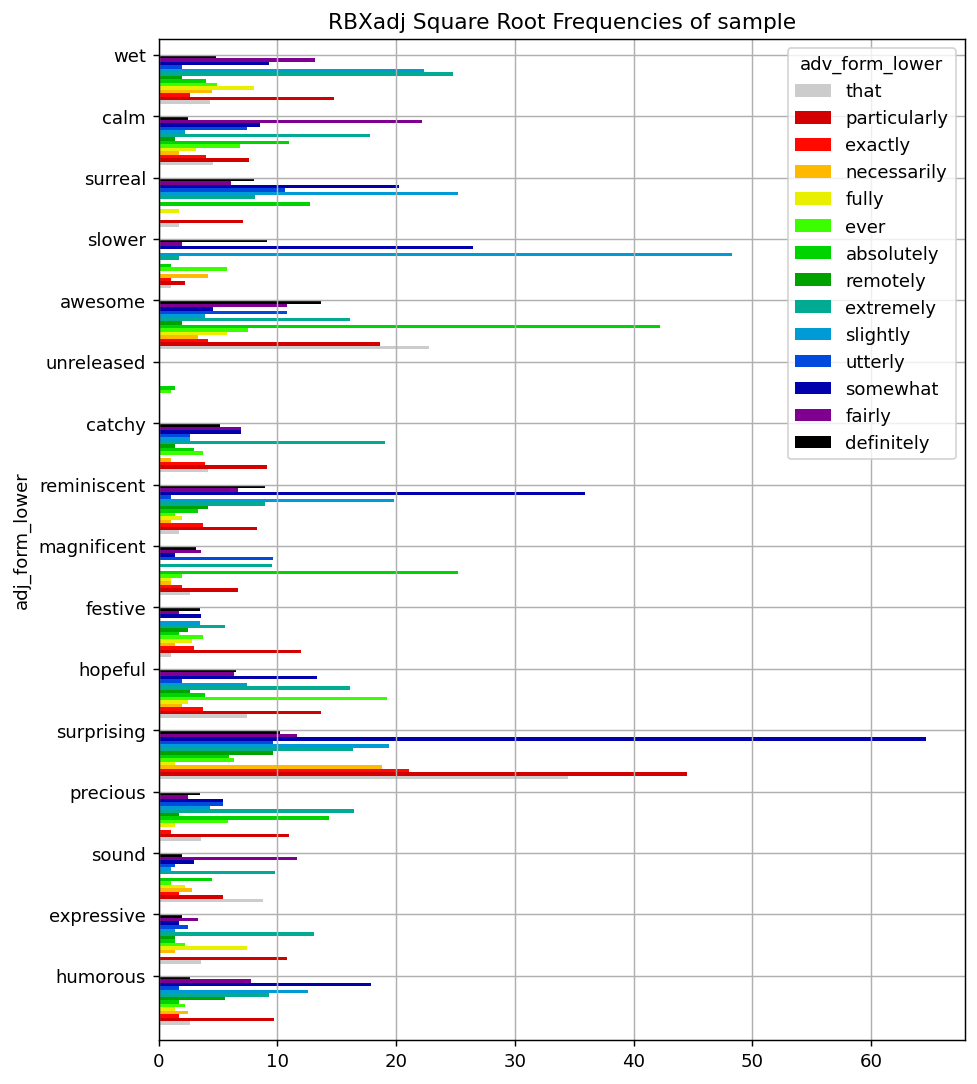

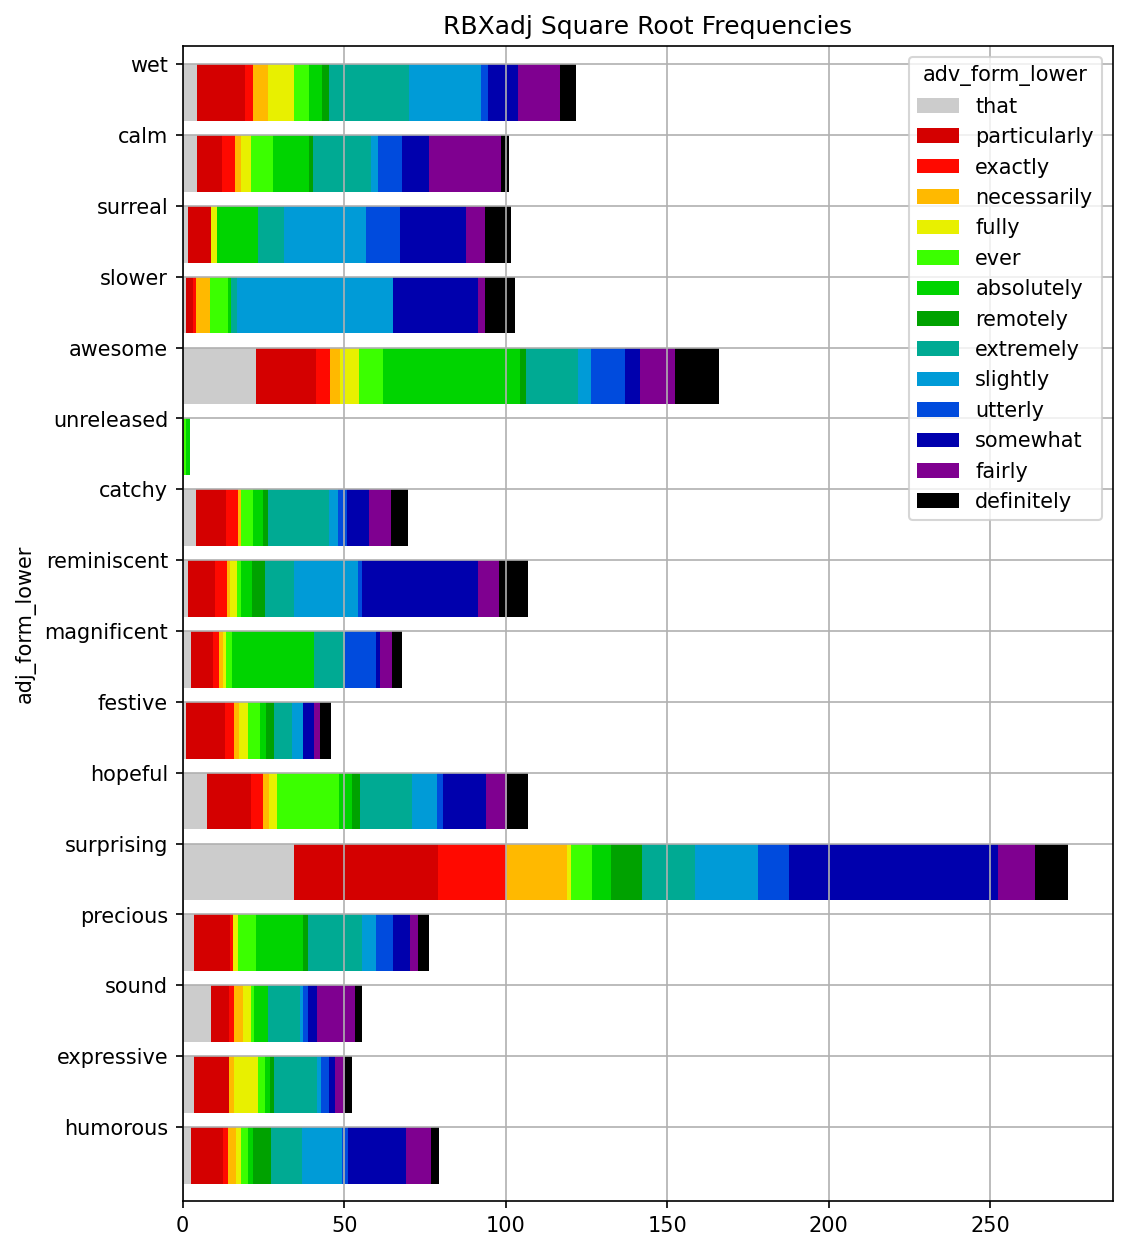

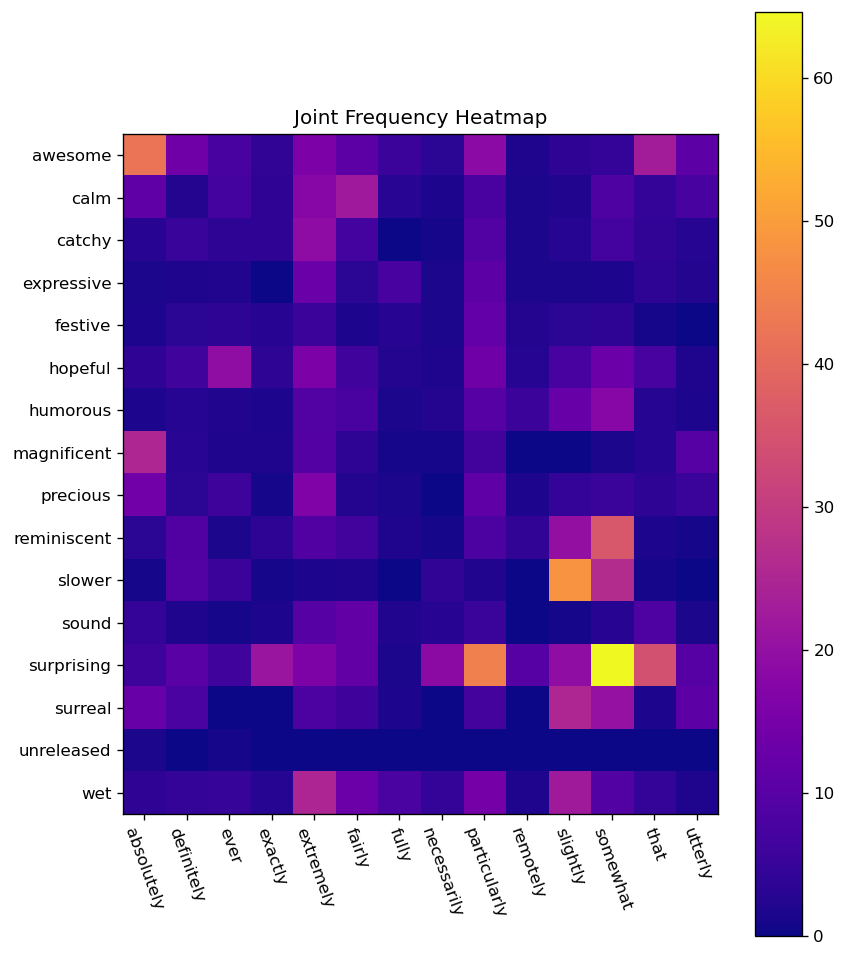

In [33]:
adv_list = sort_by_margins(
    neg_frq[['exactly', 'definitely', 'necessarily','fully', 'fairly', 'somewhat', 'particularly', 
             'extremely', 'that', 'ever', 'remotely', 'slightly', 'utterly', 'absolutely']]
    ).columns.to_list()

__, sample_all = sample_counts(transform_counts(all_frq), label='RBXadj Square Root Frequencies', columns=adv_list)
# print(sample_all.describe().to_markdown(floatfmt=',.0f'))
adj_list = sample_all.sort_index().index.to_list()

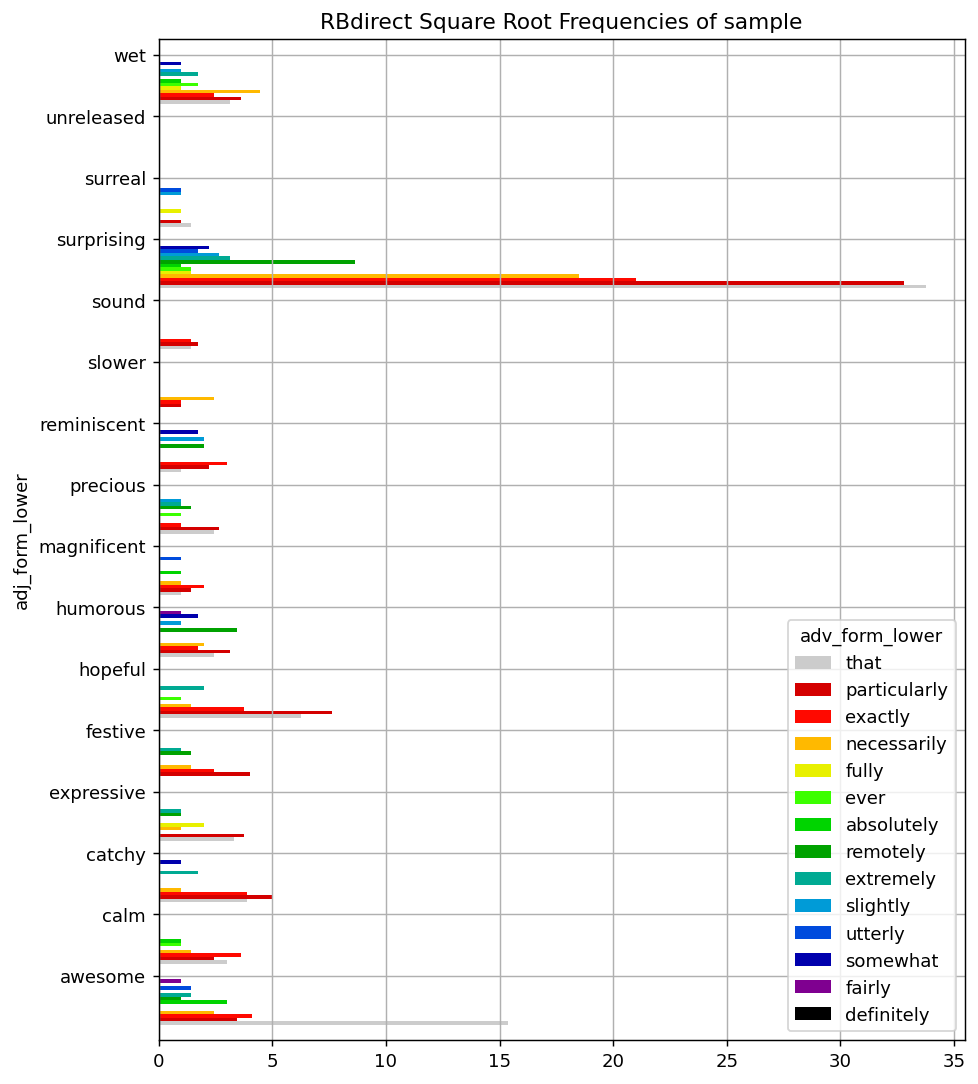

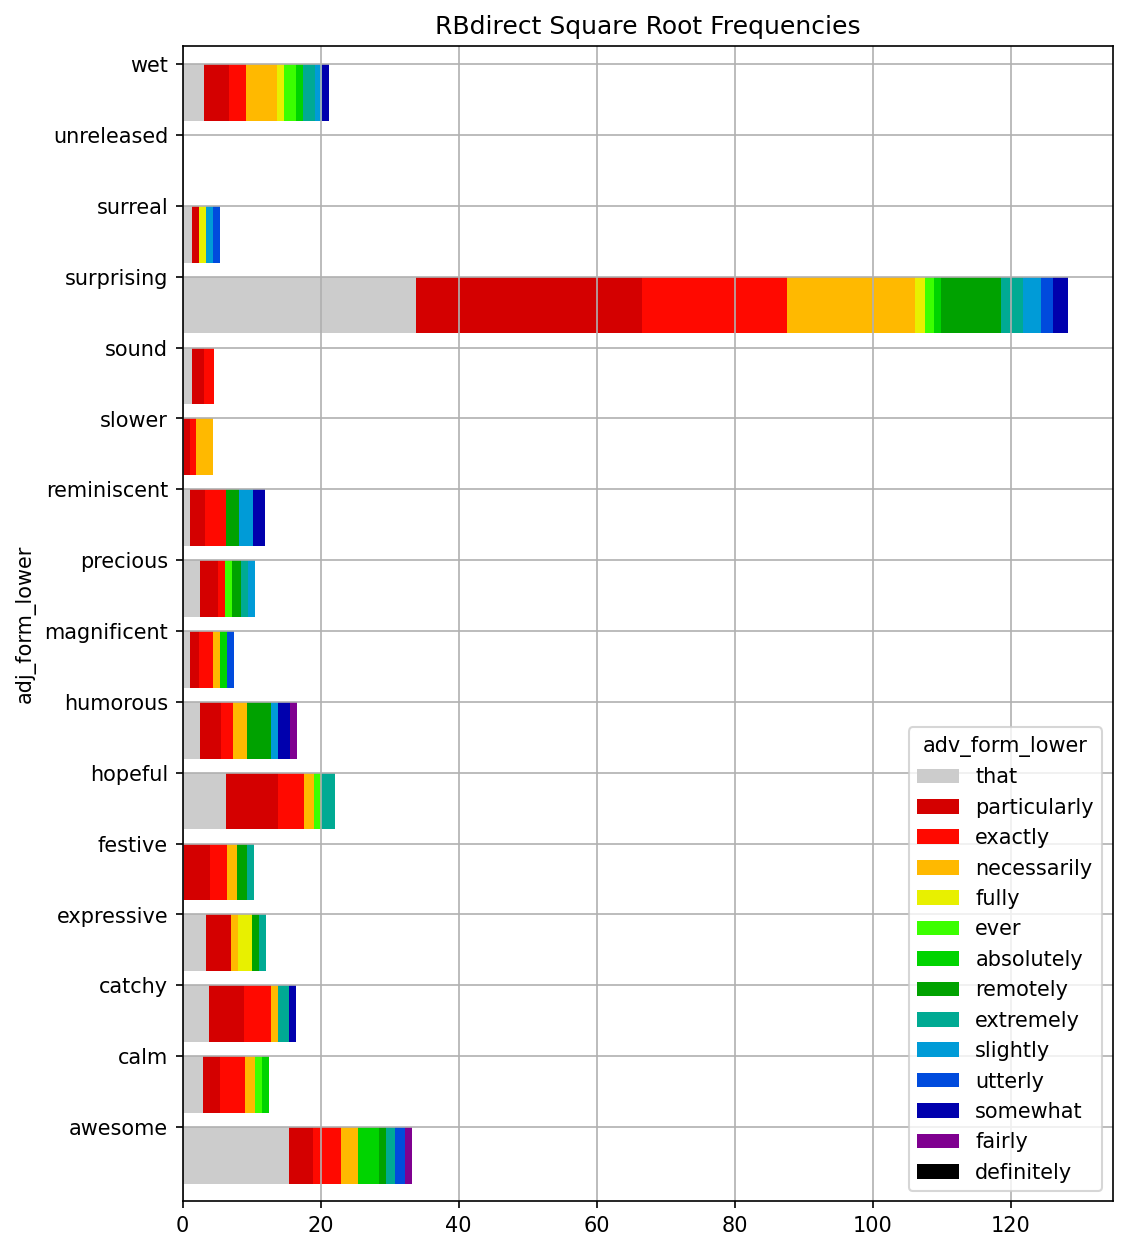

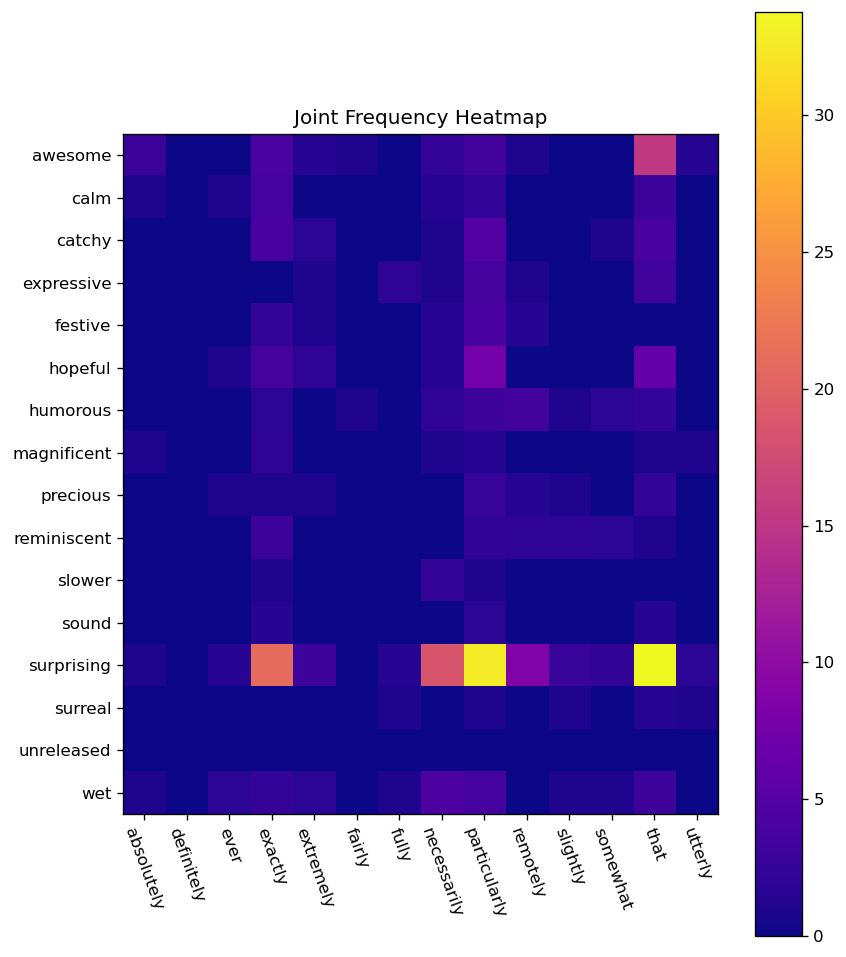

In [34]:
__, sample_neg = sample_counts(transform_counts(neg_frq).reindex_like(all_frq), 
                               rows=adj_list, 
                               columns=adv_list,
                               label='RBdirect Square Root Frequencies')

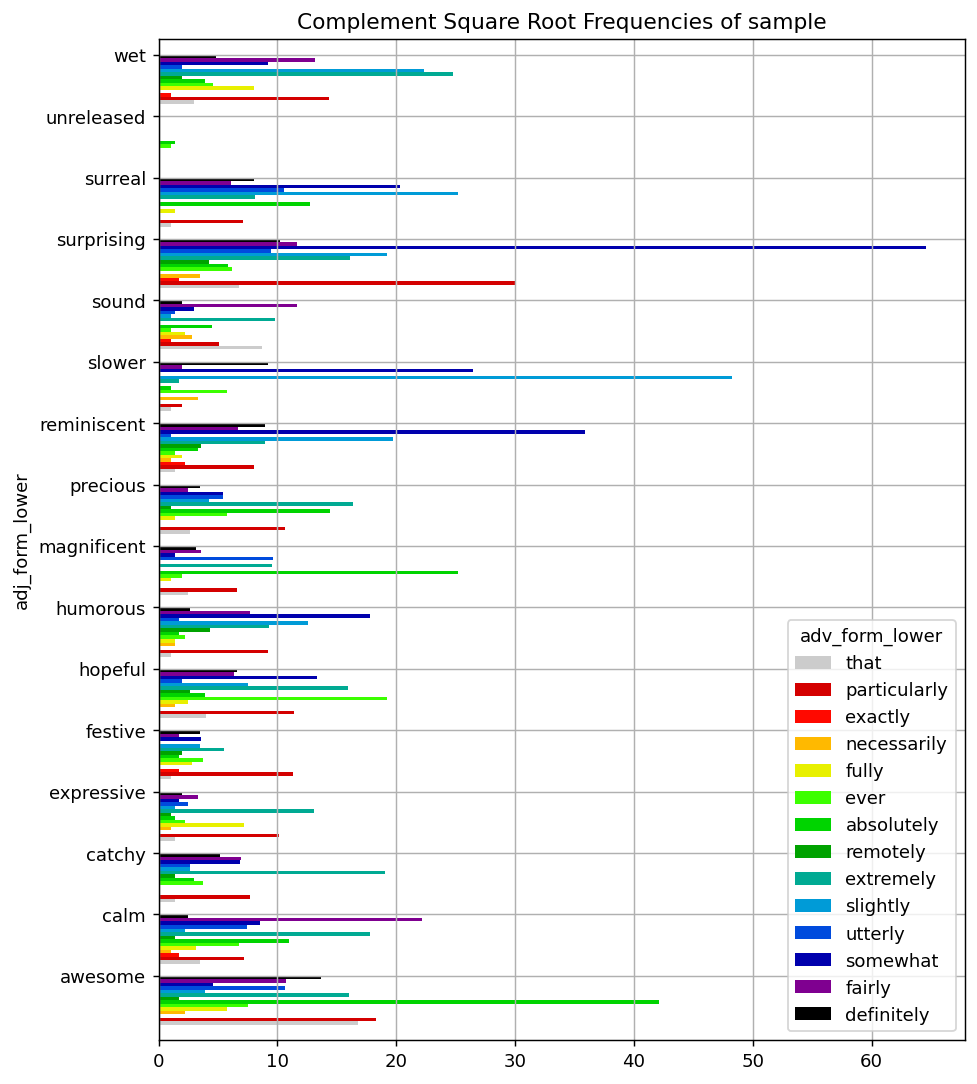

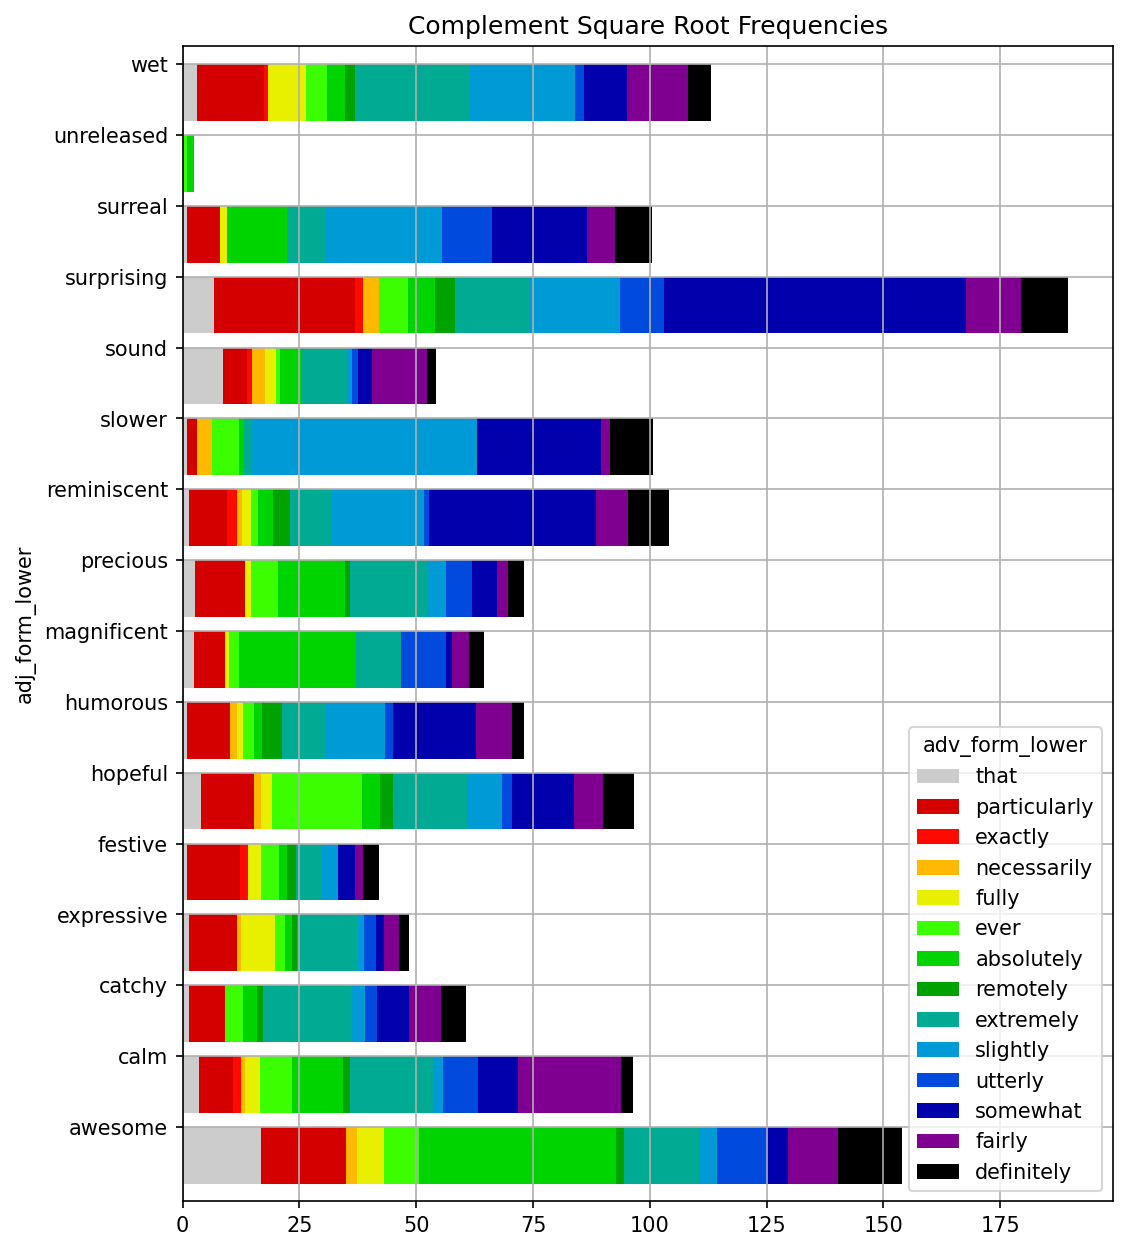

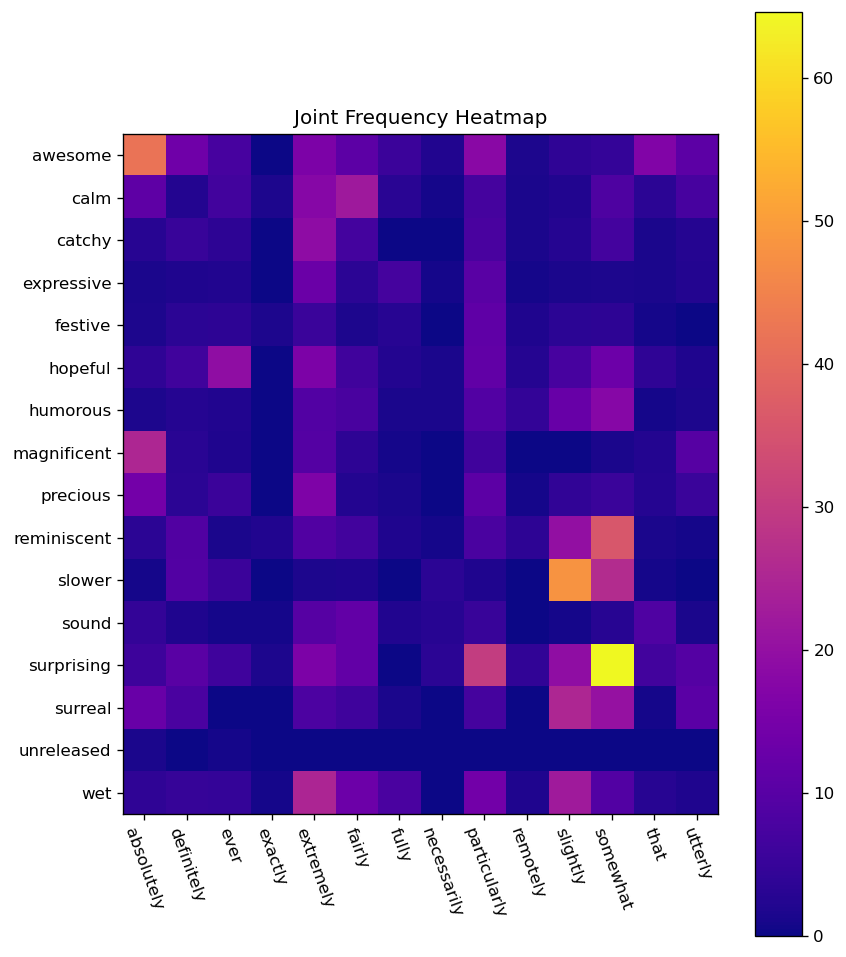

In [35]:
__, sample_diff = sample_counts(transform_counts(frq_diff).reindex_like(all_frq), 
                               rows=adj_list, 
                               columns=adv_list,
                               label='Complement Square Root Frequencies')

In [36]:
compare_sample = pd.concat([sample_neg.T.add_suffix('-NOT').T, sample_diff]).sort_index()
compare_sample = compare_sample.iloc[:-6, :]

# join(sample_diff).sort_index(axis=1)
print(compare_sample.round(2).to_markdown(floatfmt='.2f'))


| adj_form_lower   |   that |   particularly |   exactly |   necessarily |   fully |   ever |   absolutely |   remotely |   extremely |   slightly |   utterly |   somewhat |   fairly |   definitely |
|:-----------------|-------:|---------------:|----------:|--------------:|--------:|-------:|-------------:|-----------:|------------:|-----------:|----------:|-----------:|---------:|-------------:|
| awesome          |  16.79 |          18.28 |      0.00 |          2.24 |    5.74 |   7.55 |        42.10 |       1.73 |       16.03 |       3.87 |     10.68 |       4.58 |    10.72 |        13.67 |
| awesome-NOT      |  15.39 |           3.46 |      4.12 |          2.45 |    0.00 |   0.00 |         3.00 |       1.00 |        1.41 |       0.00 |      1.41 |       0.00 |     1.00 |         0.00 |
| calm             |   3.46 |           7.21 |      1.73 |          1.00 |    3.16 |   6.78 |        10.95 |       1.41 |       17.80 |       2.24 |      7.42 |       8.54 |    22.18 |         2.45 |


| adj_form_lower   |   that |   particularly |   exactly |   necessarily |   fully |   ever |   absolutely |   remotely |   extremely |   slightly |   utterly |   somewhat |   fairly |   definitely |
|:-----------------|-------:|---------------:|----------:|--------------:|--------:|-------:|-------------:|-----------:|------------:|-----------:|----------:|-----------:|---------:|-------------:|
| awesome          |  16.79 |          18.28 |      0.00 |          2.24 |    5.74 |   7.55 |        42.10 |       1.73 |       16.03 |       3.87 |     10.68 |       4.58 |    10.72 |        13.67 |
| awesome-NOT      |  15.39 |           3.46 |      4.12 |          2.45 |    0.00 |   0.00 |         3.00 |       1.00 |        1.41 |       0.00 |      1.41 |       0.00 |     1.00 |         0.00 |
| calm             |   3.46 |           7.21 |      1.73 |          1.00 |    3.16 |   6.78 |        10.95 |       1.41 |       17.80 |       2.24 |      7.42 |       8.54 |    22.18 |         2.45 |
| calm-NOT         |   3.00 |           2.45 |      3.61 |          1.41 |    0.00 |   1.00 |         1.00 |       0.00 |        0.00 |       0.00 |      0.00 |       0.00 |     0.00 |         0.00 |
| catchy           |   1.41 |           7.68 |      0.00 |          0.00 |    0.00 |   3.74 |         3.00 |       1.41 |       19.03 |       2.65 |      2.65 |       6.86 |     6.93 |         5.20 |
| catchy-NOT       |   3.87 |           5.00 |      3.87 |          1.00 |    0.00 |   0.00 |         0.00 |       0.00 |        1.73 |       0.00 |      0.00 |       1.00 |     0.00 |         0.00 |
| expressive       |   1.41 |          10.15 |      0.00 |          1.00 |    7.21 |   2.24 |         1.41 |       1.00 |       13.04 |       1.41 |      2.45 |       1.73 |     3.32 |         2.00 |
| expressive-NOT   |   3.32 |           3.74 |      0.00 |          1.00 |    2.00 |   0.00 |         0.00 |       1.00 |        1.00 |       0.00 |      0.00 |       0.00 |     0.00 |         0.00 |
| festive          |   1.00 |          11.27 |      1.73 |          0.00 |    2.83 |   3.74 |         1.73 |       2.00 |        5.48 |       3.46 |      0.00 |       3.61 |     1.73 |         3.46 |
| festive-NOT      |   0.00 |           4.00 |      2.45 |          1.41 |    0.00 |   0.00 |         0.00 |       1.41 |        1.00 |       0.00 |      0.00 |       0.00 |     0.00 |         0.00 |
| hopeful          |   4.00 |          11.36 |      0.00 |          1.41 |    2.45 |  19.21 |         3.87 |       2.65 |       15.97 |       7.48 |      2.00 |      13.30 |     6.32 |         6.56 |
| hopeful-NOT      |   6.24 |           7.62 |      3.74 |          1.41 |    0.00 |   1.00 |         0.00 |       0.00 |        2.00 |       0.00 |      0.00 |       0.00 |     0.00 |         0.00 |
| humorous         |   1.00 |           9.17 |      0.00 |          1.41 |    1.41 |   2.24 |         1.73 |       4.36 |        9.33 |      12.57 |      1.73 |      17.78 |     7.68 |         2.65 |
| humorous-NOT     |   2.45 |           3.16 |      1.73 |          2.00 |    0.00 |   0.00 |         0.00 |       3.46 |        0.00 |       1.00 |      0.00 |       1.73 |     1.00 |         0.00 |
| magnificent      |   2.45 |           6.56 |      0.00 |          0.00 |    1.00 |   2.00 |        25.18 |       0.00 |        9.54 |       0.00 |      9.59 |       1.41 |     3.61 |         3.16 |
| magnificent-NOT  |   1.00 |           1.41 |      2.00 |          1.00 |    0.00 |   0.00 |         1.00 |       0.00 |        0.00 |       0.00 |      1.00 |       0.00 |     0.00 |         0.00 |
| precious         |   2.65 |          10.63 |      0.00 |          0.00 |    1.41 |   5.74 |        14.39 |       1.00 |       16.40 |       4.24 |      5.39 |       5.39 |     2.45 |         3.46 |
| precious-NOT     |   2.45 |           2.65 |      1.00 |          0.00 |    0.00 |   1.00 |         0.00 |       1.41 |        1.00 |       1.00 |      0.00 |       0.00 |     0.00 |         0.00 |
| reminiscent      |   1.41 |           8.00 |      2.24 |          1.00 |    2.00 |   1.41 |         3.32 |       3.61 |        8.94 |      19.70 |      1.00 |      35.90 |     6.71 |         8.94 |
| reminiscent-NOT  |   1.00 |           2.24 |      3.00 |          0.00 |    0.00 |   0.00 |         0.00 |       2.00 |        0.00 |       2.00 |      0.00 |       1.73 |     0.00 |         0.00 |
| slower           |   1.00 |           2.00 |      0.00 |          3.32 |    0.00 |   5.74 |         1.00 |       0.00 |        1.73 |      48.26 |      0.00 |      26.46 |     2.00 |         9.17 |
| slower-NOT       |   0.00 |           1.00 |      1.00 |          2.45 |    0.00 |   0.00 |         0.00 |       0.00 |        0.00 |       0.00 |      0.00 |       0.00 |     0.00 |         0.00 |
| sound            |   8.72 |           5.10 |      1.00 |          2.83 |    2.24 |   1.00 |         4.47 |       0.00 |        9.80 |       1.00 |      1.41 |       3.00 |    11.66 |         2.00 |
| sound-NOT        |   1.41 |           1.73 |      1.41 |          0.00 |    0.00 |   0.00 |         0.00 |       0.00 |        0.00 |       0.00 |      0.00 |       0.00 |     0.00 |         0.00 |
| surprising       |   6.78 |          30.08 |      1.73 |          3.46 |    0.00 |   6.16 |         5.83 |       4.24 |       16.09 |      19.24 |      9.49 |      64.61 |    11.62 |        10.25 |
| surprising-NOT   |  33.78 |          32.80 |     21.00 |         18.52 |    1.41 |   1.41 |         1.00 |       8.66 |        3.16 |       2.65 |      1.73 |       2.24 |     0.00 |         0.00 |


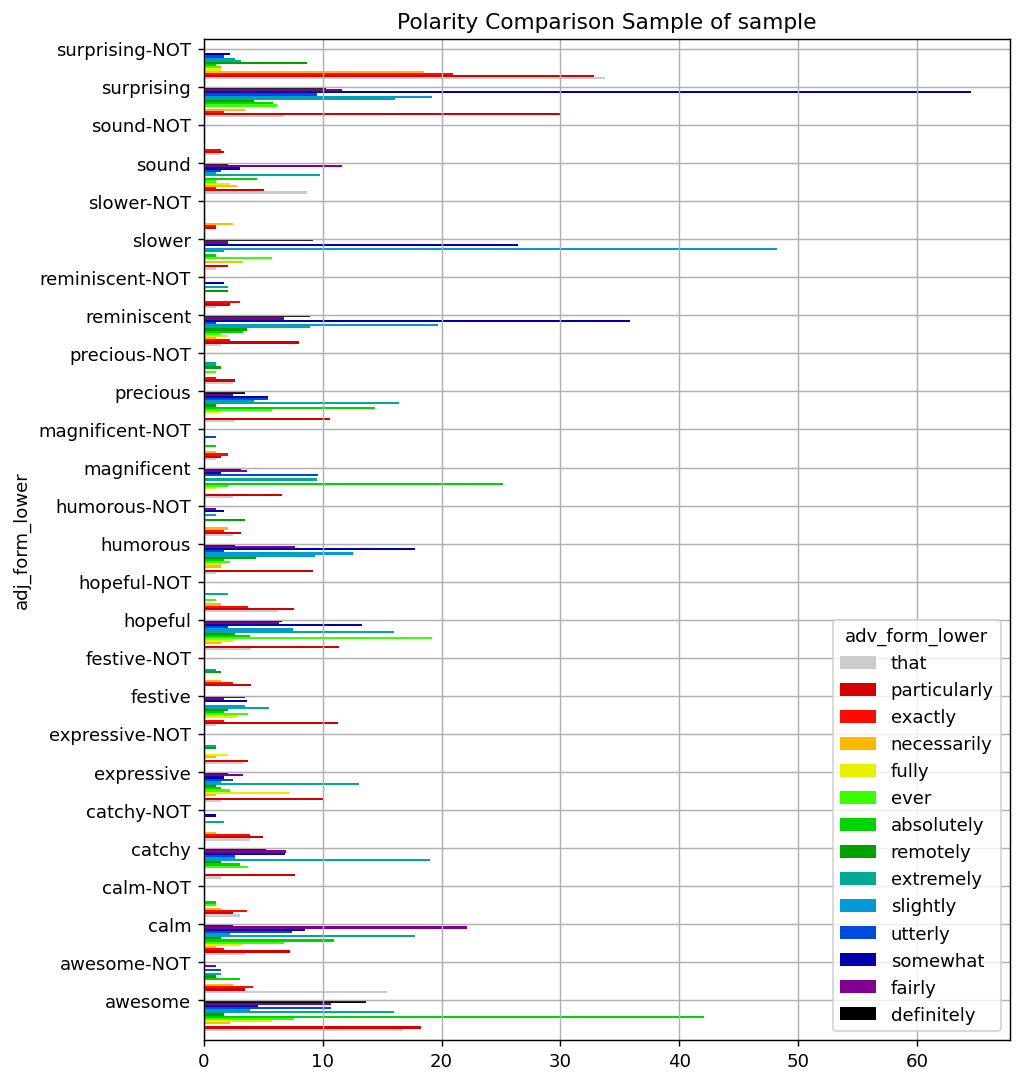

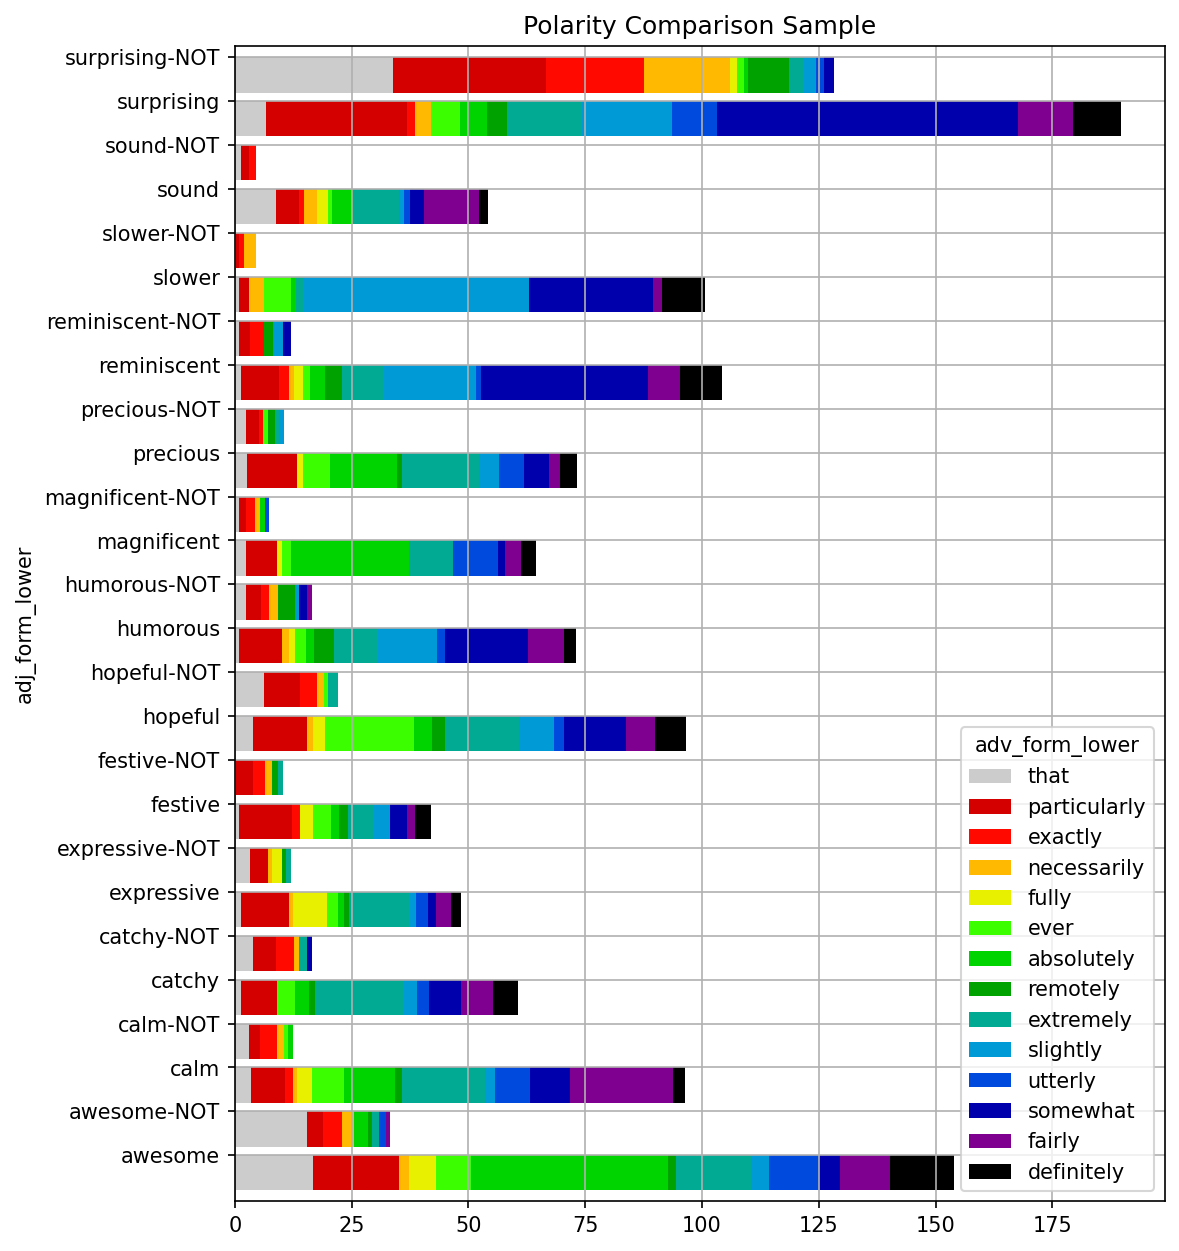

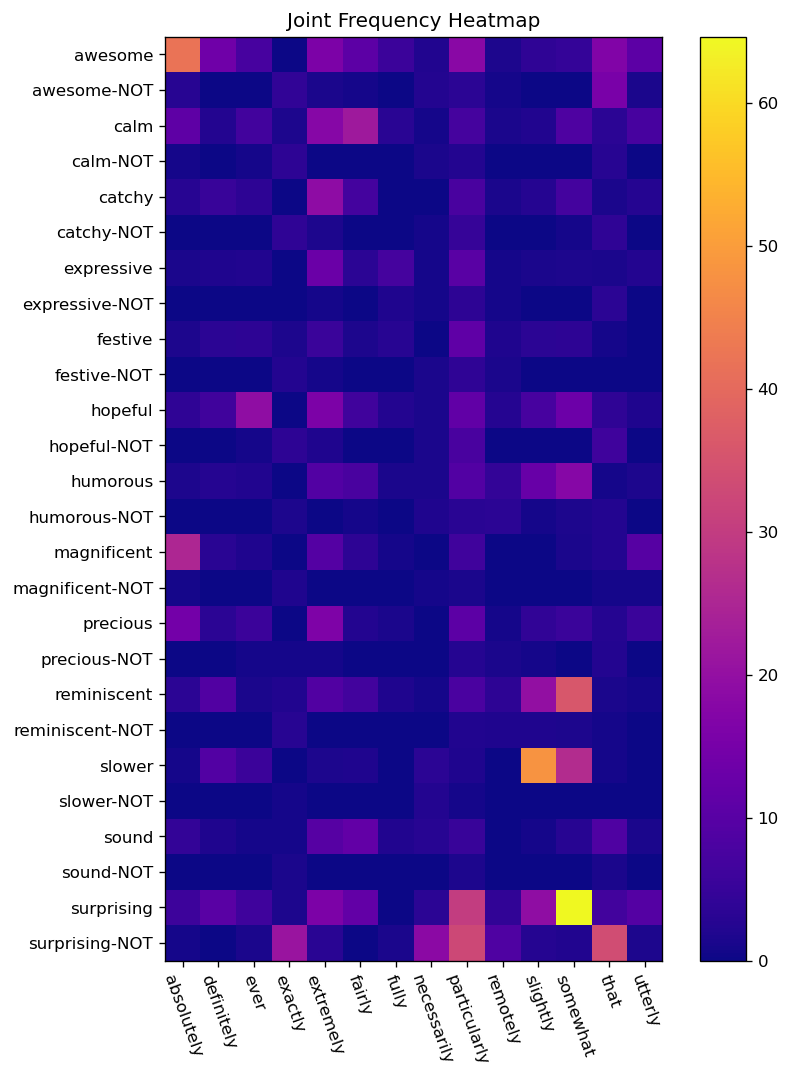

In [37]:
__ = sample_counts(compare_sample, columns=compare_sample.columns, rows=compare_sample.index, label='Polarity Comparison Sample')

## Investigating specific words

In [62]:
# TODO: extend this beyond "ever". # [ ] change to function?

all_frq['ever']

adj_form_lower
SUM           117695
many             206
important        518
good             756
much             156
               ...  
untrained          0
carnal             1
contiguous         0
panicked           0
oversized          0
Name: ever, Length: 3895, dtype: uint32

In [39]:
ever=all_frq['ever'].to_frame('ever_ALL').join(pd.to_numeric(frq_diff['ever']).to_frame('ever_DIFF')).join(neg_frq['ever'].to_frame('ever_NEG'))
ever


,ever_ALL,ever_DIFF,ever_NEG
adj_form_lower,,,
SUM,117695,111867,5828
many,206,206,0
important,518,512,6
good,756,424,332
much,156,140,16
...,...,...,...
untrained,0,0,0
carnal,1,1,0
contiguous,0,0,0


In [40]:
ever.ever_DIFF['SUM']/ever.ever_ALL['SUM']

0.9504821785122562

In [41]:
ever.ever_NEG['SUM']/ever.ever_ALL['SUM']

0.049517821487743745

In [42]:
ever_sqrt = transform_counts(ever, 'sqrt').sort_values('ever_NEG', ascending=False).round(2)
ever_sqrt.head()

,ever_ALL,ever_DIFF,ever_NEG
adj_form_lower,,,
SUM,343.07,334.47,76.34
easy,25.32,14.53,20.74
good,27.50,20.59,18.22
able,37.39,34.12,15.30
perfect,22.96,17.61,14.73


In [43]:
ever_sqrt.iloc[:, 1:].fillna(0)

,ever_DIFF,ever_NEG
adj_form_lower,,
SUM,334.47,76.34
easy,14.53,20.74
good,20.59,18.22
able,34.12,15.30
perfect,17.61,14.73
...,...,...
harsher,9.80,0.00
dignified,2.24,0.00
rudimentary,0.00,0.00


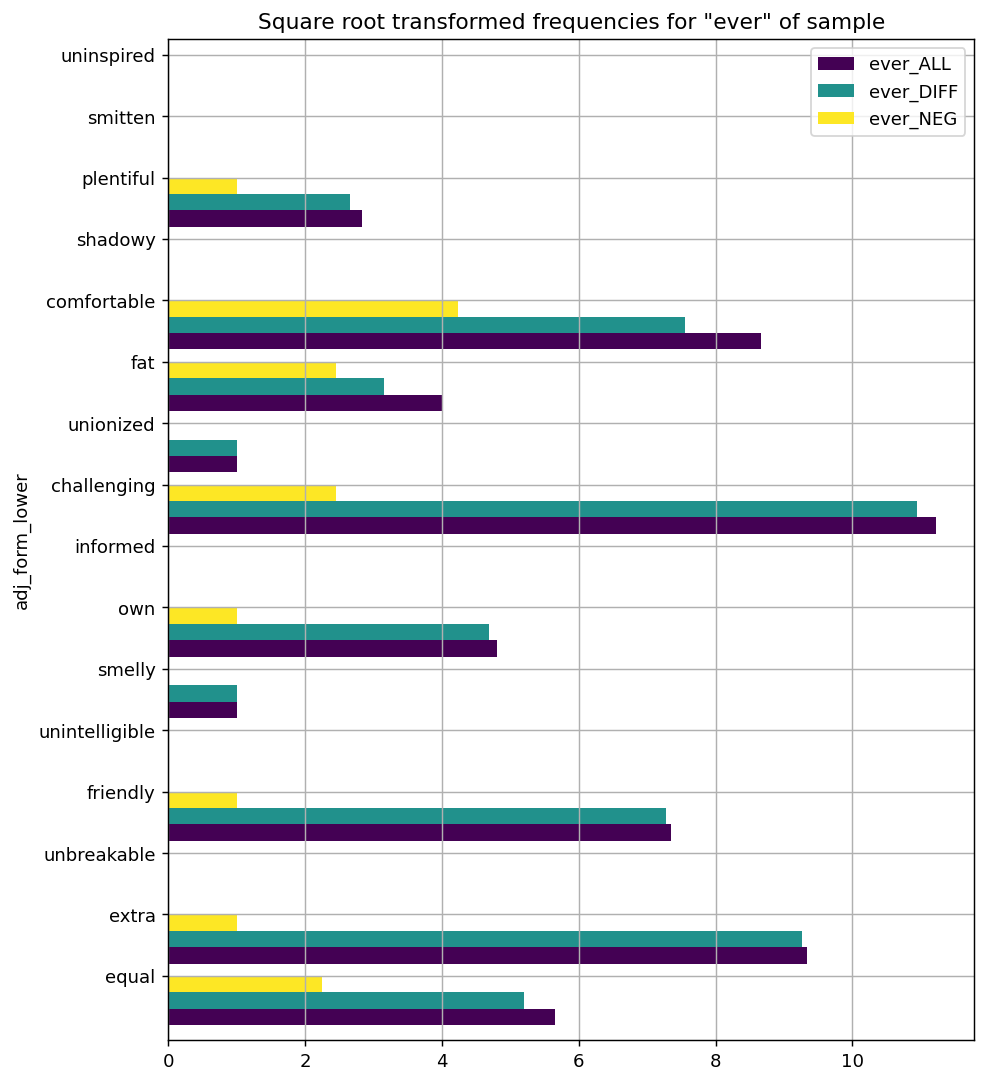

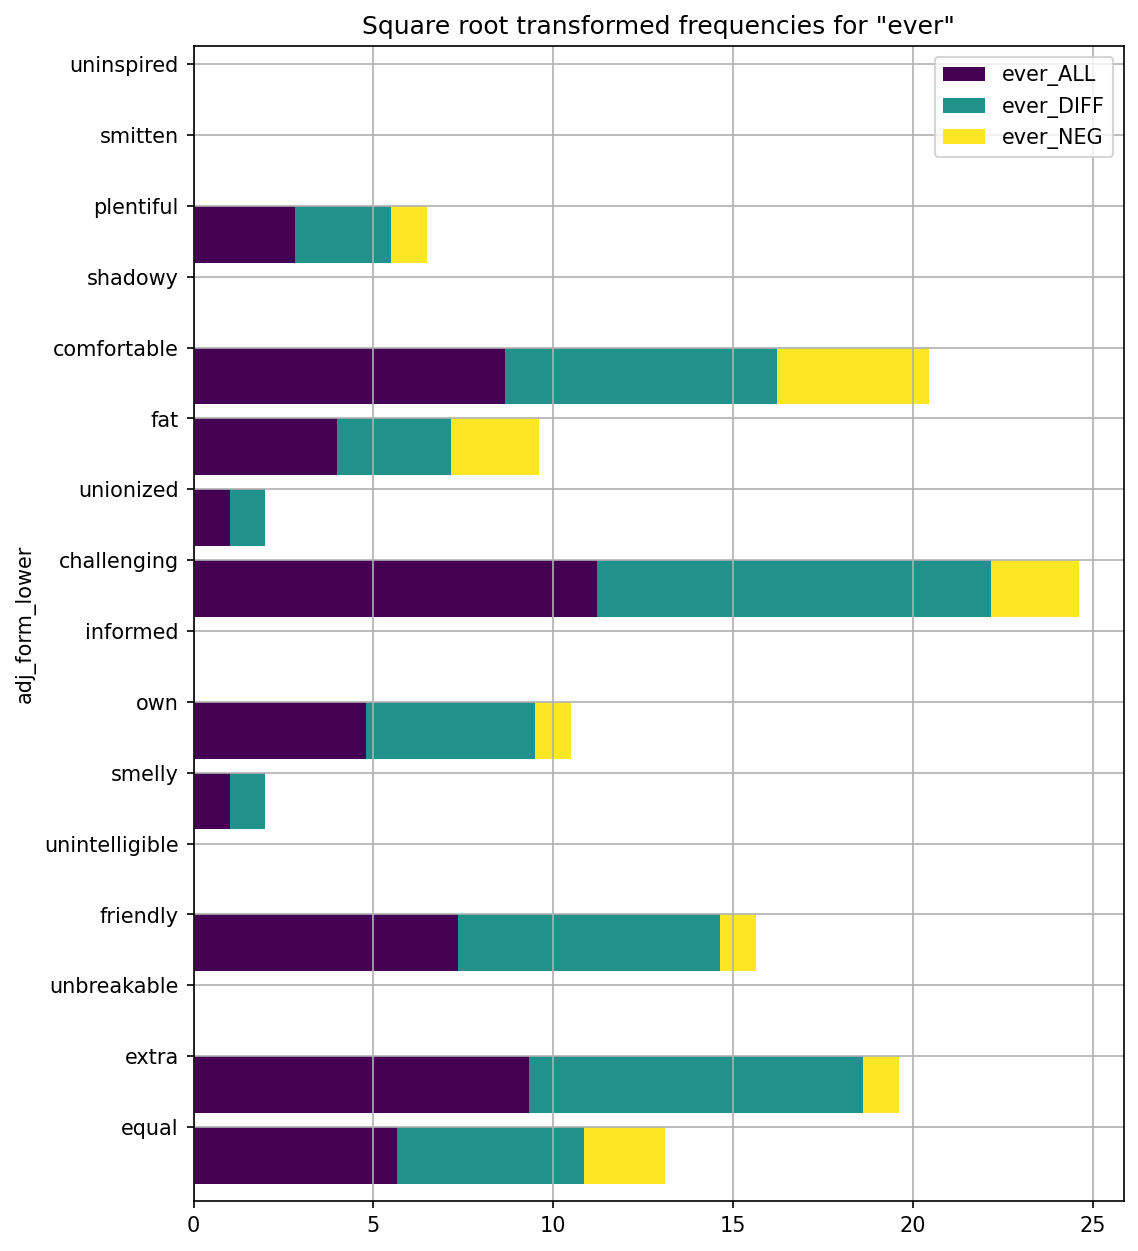

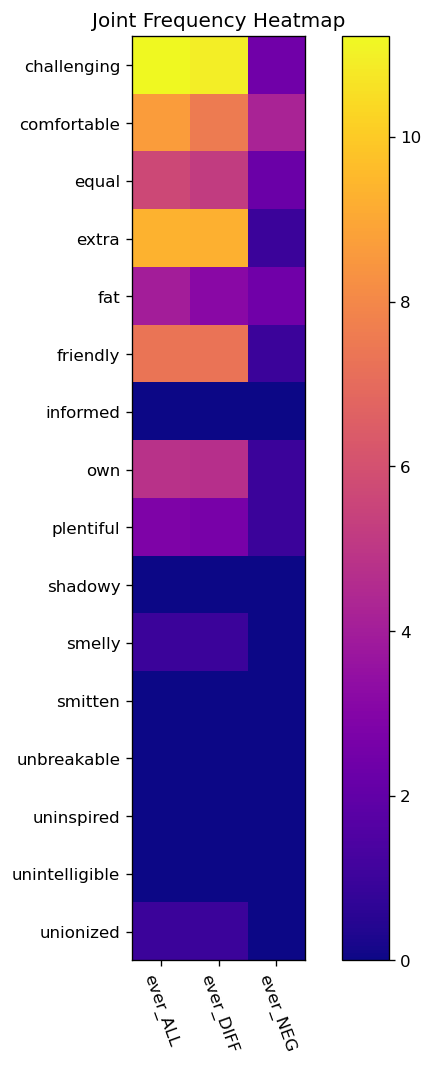

In [44]:
ever_sqrt_sample = sample_counts(ever_sqrt, label='Square root transformed frequencies for "ever"', columns=ever_sqrt.columns, color='viridis')
# corners(ever_sqrt.copy().fillna(0), 3)
# sample_counts(ever_sqrt)

### Items that did not appear _with_  direct negation 

= not in negated frequency table, `neg_frq`

(_in this sample_)

In [45]:
def show_items(index_selection, header):
    if any(index_selection):
        print_iter(index_selection, header=header , indent=2)
    else: 
        print(header, ' 🚫 N/A', sep='\n')

In [46]:
adj_never_neg = all_frq.index[~all_frq.index.isin(neg_frq.index)]
show_items(adj_never_neg, header='Adjectives not appearing in negated frequency data')

Adjectives not appearing in negated frequency data
 🚫 N/A


In [47]:
adv_never_neg = all_frq.columns[~all_frq.columns.isin(neg_frq.columns)]
show_items(adv_never_neg, header='Adverbs not appearing in negated frequency data')

Adverbs not appearing in negated frequency data
 🚫 N/A


In [48]:
all_frq.loc[adj_never_neg.to_list() + ['SUM'], adv_never_neg.to_list() + ['SUM']]

adv_form_lower,SUM
adj_form_lower,
SUM,83284343


In [49]:
neg_frq.loc[neg_frq.index.isin(adj_never_neg.to_list() + ['SUM']), neg_frq.columns.isin(adv_never_neg.to_list() + ['SUM'])]

adv_form_lower,SUM
adj_form_lower,
SUM,3148010


### Items that did not appear _without_  direct negation 

= not appearing in the "difference" frequency table, `frq_diff`

#### spoiler: 🚫 There are none.

In [50]:
adj_always_neg =neg_frq.index[~neg_frq.index.isin(frq_diff.index)]
header='Adjectives ONLY appearing in negated frequency data'
show_items(adj_always_neg, header)

Adjectives ONLY appearing in negated frequency data
 🚫 N/A


In [51]:
adv_always_neg = neg_frq.columns[~neg_frq.columns.isin(frq_diff.columns)]
show_items(adv_always_neg, header='Adverbs ONLY appearing in negated frequency data')

Adverbs ONLY appearing in negated frequency data
 🚫 N/A


In [52]:
frq_dfs = {
    'all': all_frq, 
    'neg': neg_frq, 
    'diff': frq_diff}
for name, df in frq_dfs.items():
    print_md_table(sort_by_margins(df).iloc[:19, :13], title=f'#### Top (18 x 12) collocations in {name.upper()} frequencies (+ SUM)')

#### Top (18 x 12) collocations in ALL frequencies (+ SUM)
| adj_form_lower   |        SUM |      very |      more |      most |        so |       not |        as |       too |    really |      much |    pretty |      less |       n't |
|:-----------------|-----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
| SUM              | 83,284,343 | 9,913,432 | 9,320,997 | 7,568,812 | 5,735,964 | 4,415,785 | 3,709,914 | 3,557,440 | 2,096,057 | 1,986,728 | 1,621,748 | 1,256,870 | 1,206,294 |
| many             |  2,210,387 |    21,237 |       373 |       140 | 1,191,864 |    58,442 |   434,631 |   450,194 |       518 |       201 |        54 |        54 |       580 |
| important        |  2,199,447 |   359,610 |   306,604 |   748,533 |   105,509 |    17,351 |   102,823 |    12,879 |    72,175 |     1,826 |     6,594 |    25,152 |     7,071 |
| good             |  2,030,480 |   507,499 |    18


#### Top (18 x 12) collocations in ALL frequencies (+ SUM)
| adj_form_lower   |        SUM |      very |      more |      most |        so |       not |        as |       too |    really |      much |    pretty |      less |       n't |
|:-----------------|-----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
| SUM              | 83,284,343 | 9,913,432 | 9,320,997 | 7,568,812 | 5,735,964 | 4,415,785 | 3,709,914 | 3,557,440 | 2,096,057 | 1,986,728 | 1,621,748 | 1,256,870 | 1,206,294 |
| many             |  2,210,387 |    21,237 |       373 |       140 | 1,191,864 |    58,442 |   434,631 |   450,194 |       518 |       201 |        54 |        54 |       580 |
| important        |  2,199,447 |   359,610 |   306,604 |   748,533 |   105,509 |    17,351 |   102,823 |    12,879 |    72,175 |     1,826 |     6,594 |    25,152 |     7,071 |
| good             |  2,030,480 |   507,499 |    18,902 |     5,207 |   153,196 |    96,143 |   235,348 |    59,683 |   260,281 |    14,343 |   243,692 |     2,544 |    34,203 |
| much             |  1,776,924 |    42,365 |       102 |        22 |   614,652 |    66,410 |   355,368 |   583,184 |     3,066 |       284 |    57,884 |        15 |    13,683 |
| likely           |  1,048,364 |    35,899 |   498,401 |   192,635 |       847 |    46,858 |    31,820 |     1,196 |       466 |       259 |     1,312 |   139,538 |    17,793 |
| more             |  1,028,133 |        69 |     2,280 |        90 |     2,953 |    17,641 |     2,851 |        52 |     4,561 |   355,655 |        14 |       939 |       696 |
| different        |    906,600 |   233,008 |    12,237 |     1,364 |    39,346 |     4,024 |     9,296 |     5,198 |     6,545 |    44,251 |     2,140 |       198 |       792 |
| available        |    862,942 |       403 |     9,739 |     1,384 |       490 |   132,371 |     1,879 |       277 |       552 |       979 |        32 |     1,978 |    20,868 |
| sure             |    844,066 |     4,691 |     2,324 |       315 |    35,676 |   467,213 |     3,900 |     8,714 |    20,125 |       341 |    84,366 |     2,358 |    92,560 |
| difficult        |    832,988 |   188,193 |   220,215 |    76,638 |    26,542 |    19,841 |    16,041 |    27,938 |    18,779 |       638 |     5,649 |     5,467 |     5,778 |
| popular          |    827,608 |    89,434 |    70,577 |   398,955 |    42,950 |     4,558 |    15,226 |     2,153 |     5,022 |     1,305 |     3,214 |     8,844 |     1,788 |
| easy             |    768,452 |   125,544 |     5,567 |     1,215 |    88,639 |    95,490 |    73,233 |    40,465 |    29,583 |       816 |    31,788 |     1,832 |    37,638 |
| better           |    740,721 |        93 |     1,756 |        66 |       872 |    13,540 |     1,990 |        30 |     1,770 |   295,224 |        16 |        92 |     1,819 |
| high             |    586,188 |   138,155 |     5,218 |    10,402 |    35,697 |     5,769 |    68,042 |    78,087 |    11,041 |       576 |    13,002 |       528 |     2,392 |
| common           |    555,893 |    45,763 |    85,760 |   272,787 |    15,145 |     7,175 |    11,388 |    10,439 |     1,531 |       916 |     7,186 |    16,523 |     1,347 |
| bad              |    554,698 |    50,586 |     8,470 |       703 |    89,547 |    45,132 |    70,769 |    82,159 |    49,477 |     1,675 |    20,388 |     1,743 |    19,968 |
| effective        |    530,361 |    50,857 |   141,978 |   148,925 |    11,156 |     7,561 |    27,812 |       591 |     4,532 |       508 |     2,078 |    17,454 |     2,100 |
| happy            |    526,217 |   143,139 |     5,770 |     2,767 |    79,756 |    47,886 |    11,816 |    16,447 |    37,939 |       547 |    12,490 |     3,130 |    20,152 |

#### Top (18 x 12) collocations in NEG frequencies (+ SUM)
| adj_form_lower   |       SUM |      as |      so |     too |    very |    more |    that |    only |   always |   really |   quite |   even |   entirely |
|:-----------------|----------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|---------:|---------:|--------:|-------:|-----------:|
| SUM              | 3,151,853 | 527,495 | 341,379 | 308,112 | 191,295 | 166,307 | 165,334 | 110,007 |  103,552 |   95,582 |  77,888 | 77,467 |     62,445 |
| good             |   132,519 |  44,998 |  18,026 |   3,631 |  30,415 |      32 |  10,683 |   3,332 |    1,711 |    2,527 |   1,333 |    685 |         89 |
| sure             |   128,813 |     715 |  26,602 |   8,101 |     676 |     142 |     300 |      24 |    1,169 |   17,906 |  26,173 | 14,526 |     13,049 |
| bad              |   105,249 |  27,766 |  21,376 |  19,532 |     317 |       8 |  16,559 |     679 |      916 |      720 |     101 |    111 |        275 |
| easy             |    87,572 |  23,393 |  17,611 |   1,207 |   2,736 |     147 |  10,170 |   1,351 |   24,592 |      544 |     189 |     77 |        107 |
| clear            |    72,890 |   3,462 |   3,257 |     473 |   2,646 |   1,371 |     516 |     111 |    4,024 |    1,500 |   2,310 |  1,615 |      7,531 |
| available        |    55,871 |     321 |      62 |      34 |      27 |      92 |      11 |     570 |    2,361 |      252 |      52 |    789 |         13 |
| important        |    49,973 |  12,307 |   3,415 |     687 |   1,862 |  15,218 |   5,556 |   2,764 |      136 |    1,316 |      37 |    165 |         11 |
| much             |    48,678 |   5,905 |  21,944 |  12,648 |   1,175 |       1 |   4,754 |      38 |       12 |    1,245 |       3 |    189 |          0 |
| different        |    45,681 |     617 |   5,791 |   2,364 |   3,242 |   6,798 |   6,578 |     300 |       14 |      367 |      68 |      6 |        252 |
| great            |    33,068 |   5,739 |   9,605 |   1,296 |     397 |       5 |  11,090 |   1,075 |      614 |      389 |      81 |     29 |         16 |
| big              |    30,884 |  10,776 |   2,115 |   6,442 |   2,466 |       3 |   6,281 |     168 |       57 |      579 |     349 |     92 |          1 |
| hard             |    30,862 |   1,220 |   4,602 |  10,111 |   1,684 |       9 |   9,976 |     314 |       58 |      548 |      41 |    142 |         12 |
| simple           |    30,632 |  14,759 |   6,618 |     237 |     265 |     456 |   6,165 |     263 |      629 |      107 |      77 |      7 |         24 |
| difficult        |    29,909 |   4,638 |   2,611 |   7,449 |   2,442 |   1,700 |   5,583 |     534 |       41 |      305 |      38 |     47 |         29 |
| close            |    29,510 |   2,856 |   1,540 |   1,836 |   1,028 |      14 |     583 |     101 |       56 |      552 |     130 | 17,786 |          5 |
| happy            |    29,367 |   1,765 |   3,083 |   7,363 |   4,442 |   1,151 |     781 |     219 |      628 |    1,402 |     410 |     62 |      1,176 |
| late             |    26,323 |      14 |      83 |  25,876 |      46 |       2 |      13 |      35 |        7 |       20 |       3 |     26 |          0 |
| true             |    25,794 |     444 |     501 |       8 |     101 |   1,970 |     219 |     615 |    2,944 |    1,665 |   1,866 |    526 |      3,672 |

#### Top (18 x 12) collocations in DIFF frequencies (+ SUM)
| adj_form_lower   |        SUM |      very |      more |      most |        so |       not |       too |        as |    really |      much |    pretty |      less |       n't |
|:-----------------|-----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
| SUM              | 80,132,490 | 9,722,137 | 9,154,690 | 7,549,126 | 5,394,585 | 4,408,005 | 3,249,328 | 3,182,419 | 2,000,475 | 1,933,499 | 1,619,495 | 1,242,752 | 1,202,442 |
| many             |  2,196,233 |    19,311 |       371 |       140 | 1,189,736 |    58,428 |   444,015 |   431,383 |       498 |       199 |        54 |        53 |       580 |
| important        |  2,149,474 |   357,748 |   291,386 |   747,569 |   102,094 |    17,182 |    12,192 |    90,516 |    70,859 |     1,739 |     6,585 |    24,226 |     6,832 |
| good             |  1,897,961 |   477,084 |    18,870 |     5,202 |   135,170 |    95,797 |    56,052 |   190,350 |   257,754 |    12,877 |   243,508 |     2,519 |    33,848 |
| much             |  1,728,246 |    41,190 |       101 |        22 |   592,708 |    66,385 |   570,536 |   349,463 |     1,821 |       280 |    57,867 |        15 |    13,670 |
| likely           |  1,037,851 |    33,568 |   495,782 |   192,118 |       574 |    46,814 |       899 |    29,733 |       340 |       249 |     1,310 |   139,076 |    17,777 |
| more             |  1,019,610 |        69 |     2,277 |        90 |     2,941 |    17,630 |        51 |     2,841 |     4,466 |   349,068 |        13 |       938 |       693 |
| different        |    860,919 |   229,766 |     5,439 |     1,363 |    33,555 |     4,017 |     2,834 |     8,679 |     6,178 |    33,352 |     2,138 |       193 |       790 |
| popular          |    810,240 |    86,887 |    69,046 |   398,297 |    41,441 |     4,546 |     1,699 |     9,985 |     4,868 |     1,233 |     3,209 |     8,769 |     1,774 |
| available        |    807,071 |       376 |     9,647 |     1,379 |       428 |   132,250 |       243 |     1,558 |       300 |       939 |        31 |     1,975 |    20,814 |
| difficult        |    803,079 |   185,751 |   218,515 |    76,506 |    23,931 |    19,816 |    20,489 |    11,403 |    18,474 |       464 |     5,635 |     5,300 |     5,772 |
| better           |    716,812 |        93 |     1,737 |        66 |       860 |    13,514 |        29 |     1,973 |     1,619 |   283,990 |        15 |        86 |     1,802 |
| sure             |    715,253 |     4,015 |     2,182 |       314 |     9,074 |   466,982 |       613 |     3,185 |     2,219 |       319 |    84,249 |     2,342 |    92,508 |
| easy             |    680,880 |   122,808 |     5,420 |     1,201 |    71,028 |    95,375 |    39,258 |    49,840 |    29,039 |       727 |    31,745 |     1,820 |    37,606 |
| high             |    566,514 |   135,494 |     5,211 |    10,389 |    33,614 |     5,762 |    74,784 |    60,945 |    10,869 |       549 |    12,988 |       525 |     2,389 |
| common           |    544,238 |    43,465 |    85,254 |   272,621 |    13,572 |     7,171 |     9,972 |     7,688 |     1,432 |       901 |     7,176 |    16,500 |     1,343 |
| effective        |    510,206 |    47,718 |   140,448 |   148,430 |    10,661 |     7,538 |       451 |    19,107 |     4,331 |       434 |     2,074 |    17,255 |     2,081 |
| happy            |    496,850 |   138,697 |     4,619 |     2,759 |    76,673 |    47,802 |     9,084 |    10,051 |    36,537 |       503 |    12,481 |     3,087 |    20,113 |
| interesting      |    481,885 |   105,108 |   109,391 |    84,388 |    13,133 |     2,866 |       838 |     5,517 |    42,252 |       762 |    11,917 |     6,464 |     1,470 |


### How about the bigrams considered as a unit?

There are both adverbs and adjectives that didn't make an appearance in the negated data, 
but this could easily be due to the large disparity size of the dataframes. 
So I would be incredibly hesitant to say they are sensitive to polarity (and prefer _positive polarity_). 

Total Tokens per Frequency Group
|      |     totals |
|:-----|-----------:|
| ALL  | 83,284,343 |
| NEG  |  3,151,853 |
| DIFF | 80,132,490 |

Marginal Frequencies for ALL Bigram Tokens
|       |   individual adj totals |   individual adv totals |
|:------|------------------------:|------------------------:|
| count |                   3,894 |                   1,005 |
| mean  |                  21,388 |                  82,870 |
| std   |                  91,460 |                 581,924 |
| min   |                     870 |                     868 |
| 25%   |                   1,637 |                   1,705 |
| 50%   |                   3,466 |                   4,049 |
| 75%   |                  10,673 |                  15,767 |
| max   |               2,210,387 |               9,913,432 |

Marginal Frequencies for NEG Bigram Tokens
|       |   individual adj totals |   individual adv totals |
|:------|------------------------:|------------------------:|
| count |                   3,894 |                   1,005 |
| mean  |                     809 |                   3,136 |
| std   |                   4,754 |                  25,306 |
| min   |                       0 |                       0 |
| 25%   |                      35 |                      16 |
| 50%   |                      87 |                      49 |
| 75%   |                     298 |                     206 |
| max   |                 132,519 |                 527,495 |

Marginal Frequencies for DIFF Bigram Tokens
|       |   individual adj totals |   individual adv totals |
|:------|------------------------:|------------------------:|
| count |                   3,894 |                   1,005 |
| mean  |                  20,578 |                  79,734 |
| std   |                  88,041 |                 566,463 |
| min   |                     801 |                     757 |
| 25%   |                   1,600 |                   1,661 |
| 50%   |                   3,368 |                   3,969 |
| 75%   |                  10,265 |                  15,222 |
| max   |               2,196,233 |               9,722,137 |



In [53]:
totals = pd.Series({name.upper(): frq_df.loc['SUM', 'SUM'] 
                    for name, frq_df in frq_dfs.items()}
                   ).to_frame('totals')
print_md_table(totals, title='Total Tokens per Frequency Group')

for name, neg_frq in frq_dfs.items():
    print_md_table(neg_frq['SUM'].iloc[1:].describe().to_frame('individual adj totals').join(
        neg_frq.T['SUM'].iloc[1:].describe().to_frame('individual adv totals')), 
                   title=f'Marginal Frequencies for {name.upper()} Bigram Tokens')

Total Tokens per Frequency Group
|      |     totals |
|:-----|-----------:|
| ALL  | 83,284,343 |
| NEG  |  3,148,010 |
| DIFF | 80,136,333 |
Marginal Frequencies for ALL Bigram Tokens
|       |   individual adj totals |   individual adv totals |
|:------|------------------------:|------------------------:|
| count |                   3,894 |                   1,005 |
| mean  |                  21,388 |                  82,870 |
| std   |                  91,460 |                 581,924 |
| min   |                     870 |                     868 |
| 25%   |                   1,637 |                   1,705 |
| 50%   |                   3,466 |                   4,049 |
| 75%   |                  10,673 |                  15,767 |
| max   |               2,210,387 |               9,913,432 |
Marginal Frequencies for NEG Bigram Tokens
|       |   individual adj totals |   individual adv totals |
|:------|------------------------:|------------------------:|
| count |                  

In [54]:
def get_ratio(df, transpose=False):
    all_vals = all_frq.transpose() if transpose else all_frq
    return df.apply(lambda c: c / all_vals['SUM']).sort_values('SUM', ascending=False).sort_values('SUM',axis=1, ascending=False)

In [55]:
# FIXME #BUG `neg_frq` has been overwritten by complement somewhere above...
neg_frq

adv_form_lower,SUM,very,more,most,so,not,as,too,really,much,...,scandalously,urgently,intolerably,madly,touchingly,on,emphatically,second-most,cosmetically,pointedly
adj_form_lower,,,,,,,,,,,,,,,,,,,,,
SUM,80136333,9722389,9154821,7549147,5394914,4408045,3183087,3249570,2000598,1933545,...,872,858,858,841,867,853,862,869,815,853
many,2196242,19312,371,140,1189736,58428,431385,444021,498,199,...,0,0,0,0,0,1,3,0,0,0
important,2149576,357754,291396,747570,102101,17182,90543,12196,70866,1739,...,0,119,1,1,0,0,2,105,9,0
good,1898254,477150,18870,5202,135194,95800,190463,56060,257760,12879,...,11,2,1,4,1,1,6,0,6,0
much,1728295,41190,101,22,592727,66385,349470,570546,1823,280,...,0,0,0,0,0,92,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
untrained,864,9,10,43,11,5,14,8,1,1,...,0,0,0,0,0,0,0,0,0,0
carnal,857,34,150,61,26,234,20,10,3,3,...,0,0,0,0,0,0,0,0,0,0
contiguous,814,3,106,8,6,200,6,1,2,5,...,0,0,0,0,0,0,0,0,0,0


In [56]:
def get_totals_frame(neg_frq, frq_diff, transpose=False):
    if transpose: 
        neg_frq= neg_frq.transpose()
        frq_diff= frq_diff.transpose()
        
    neg_ratio_frq = get_ratio(neg_frq, transpose=transpose)
    diff_ratio_frq = get_ratio(frq_diff, transpose=transpose)

    totals_df=neg_ratio_frq['SUM'].to_frame('NEG/ALL')
    totals_df['DIFF/ALL'] = diff_ratio_frq['SUM']
    totals_df['NEG_RAW'] = neg_frq['SUM']
    totals_df['DIFF_RAW'] = frq_diff['SUM']
    return totals_df

In [57]:
adj_totals = get_totals_frame(neg_frq, frq_diff, transpose=False)
adj_totals.head(15)

,NEG/ALL,DIFF/ALL,NEG_RAW,DIFF_RAW
adj_form_lower,,,,
evolving,1.000000,1.000000,3141,3141
southerly,1.000000,1.000000,1426,1426
northerly,1.000000,1.000000,1890,1890
chopped,1.000000,1.000000,1293,1293
away,1.000000,1.000000,1291,1291
null,1.000000,1.000000,1063,1063
worldwide,1.000000,1.000000,963,963
marrow,1.000000,1.000000,1168,1168
earliest,1.000000,1.000000,2199,2199


In [58]:
adv_totals = get_totals_frame(neg_frq, frq_diff, transpose=True)
adv_totals.head(15)

,NEG/ALL,DIFF/ALL,NEG_RAW,DIFF_RAW
adv_form_lower,,,,
legendarily,1.000000,1.000000,981,981
sparsely,1.000000,1.000000,1281,1281
yearly,1.000000,1.000000,2218,2218
second-most,1.000000,1.000000,869,869
albeit,0.999810,0.999810,15764,15764
preferably,0.999757,0.999757,4110,4110
alternately,0.999721,0.999721,3588,3588
increasingly,0.999595,0.999595,390385,390385
unseasonably,0.999510,0.999510,2038,2038


In [59]:
print(all_frq.loc[frq_diff.min(axis=1) ==-2, frq_diff.min() ==-2].join(
    neg_frq.loc[frq_diff.min(axis=1) ==-2, frq_diff.min() ==-2], rsuffix='_neg').join(
    frq_diff.loc[frq_diff.min(axis=1) ==-2, frq_diff.min() ==-2], rsuffix='_diff').to_markdown(floatfmt=',.0f'))

| adj_form_lower   |
|------------------|



### ⚠️ RBdirect double-dipping

The `frq_diff` dataframe contains negative values because there are certain bigrams are flagged multiple times by the negation patterns.

That is, there are multiple `NEG` nodes in the parse with a direct tie to `ADJ`. They are not both _valid_,
but at the current time (Dec 7, 2023) no checks are in place to select the appropriate hit.
Which negation is selected is probably not a huge deal, since, if the different `NEG` nodes have the same case-normalized form,
they are identical in regards to the basic frequency tables. 
(It matters more if more specific `dep_str*` values are used, especially if the relation type differs as well.)


### ❗ For now, `RBdirect` frequencies will be overriden manually
but this needs to be addressed. There is no telling how many such cases there are---I'm 
lucky that there were some relevant bigrams with counts low enough to throw an error



- [ ] add code to import `transform_counts` using `sqrt`